### Loading required libraries

In [206]:
# Loading required libraries

#special IPython command to prepare the notebook for matplotlib
%matplotlib inline

#test file related libraries
import glob
import csv

#import libraries
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
from statsmodels.nonparametric.api import lowess
#from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import sklearn.decomposition
import sklearn.cluster
from matplotlib import gridspec
#import seaborn as sns
import datetime

#set default plot characterstics and colors
from matplotlib import rcParams

dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="white"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 1
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# Supressing the print output of warnings
import warnings
warnings.filterwarnings("ignore")

### Loading Station Names File

In [2]:
# Reading the file
stations = pd.read_csv('station_names.txt', sep='|')
print(stations.shape)
print(stations.columns)
stations.head()

(253, 2)
Index(['dock_id', 'dock_name'], dtype='object')


,dock_id,dock_name
0,72,W 52 St & 11 Ave
1,79,Franklin St & W Broadway
2,82,St James Pl & Pearl St
3,83,Atlantic Ave & Fort Greene Pl
4,119,Park Ave & St Edwards St


In [129]:
# Station list
lst = [72, 119, 137]
stations[stations['dock_id'].isin(lst)]

,dock_id,dock_name
0,72,W 52 St & 11 Ave
4,119,Park Ave & St Edwards St
7,137,E 56 St & Madison Ave


1. 72 dock id shows a trend of high usage in afternoons, parks, museums, preferred by tourists, lack of public transit mode, Manhattan

2. 119 dock id shows a consistent trend across the day, probably a residential area, Brooklyn

3. 137 dock id shows a trend of high usage in mornings and evenings, preferred by work related commuters and other commercial activity, Manhattan


### Weather data

Weather data (precipitation in inches), snowfall in inches, and temperature in degress Fahrenheit) was scraped from the weathersource.com API for every hour of the 2012 season. 
The weathersource.com API limits the number of lines per query to 24 and the number of queries per minute to 10. To deal with this, we wrote a python function(see "scrape_weather.py") to loop through each day of the 2012 season with a pause of 6 seconds between each day. This allows for the relevant data to be obtained while respecting the weathersource terms of use. The resulting process takes about 20 minutes. The result of each query was saved to a pandas dataframe. This dataframe was exported to a csv which can be loaded directly from our github page.

In [3]:
weather = pd.read_csv('weather.csv')
weather.columns = ['index', 'precip', 'snowfall', 'temp', 'timestamp', 'datetime']
weather.drop('timestamp', axis=1, inplace=True)
weather['datetime'] = pd.to_datetime(weather['datetime'], utc=True)
weather.head()

,index,precip,snowfall,temp,datetime
0,0,0,0,25.7,2015-03-01 00:00:00
1,1,0,0,24.8,2015-03-01 01:00:00
2,2,0,0,22.8,2015-03-01 02:00:00
3,3,0,0,21.1,2015-03-01 03:00:00
4,4,0,0,20.1,2015-03-01 04:00:00


In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6600 entries, 0 to 6599
Data columns (total 5 columns):
index       6600 non-null int64
precip      6586 non-null float64
snowfall    6586 non-null float64
temp        6586 non-null float64
datetime    6600 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 309.4 KB


In [5]:
# Looking at descriptive statistics
weather.describe()

,index,precip,snowfall,temp
count,6600.00000,6586.000000,6586.000000,6586.000000
mean,3299.50000,0.003237,0.000729,58.635500
std,1905.40022,0.019196,0.016700,15.977724
min,0.00000,0.000000,0.000000,-2.000000
25%,1649.75000,0.000000,0.000000,47.400000
50%,3299.50000,0.000000,0.000000,60.000000
75%,4949.25000,0.000000,0.000000,71.000000
max,6599.00000,0.520000,0.700000,93.900000


In [6]:
# Looking at missing values in the columns
weather[weather['temp'].isnull()]

,index,precip,snowfall,temp,datetime
6346,6346,NaN,NaN,NaN,2015-11-20 10:00:00
6347,6347,NaN,NaN,NaN,2015-11-20 11:00:00
6348,6348,NaN,NaN,NaN,2015-11-20 12:00:00
6349,6349,NaN,NaN,NaN,2015-11-20 13:00:00
6350,6350,NaN,NaN,NaN,2015-11-20 14:00:00
6351,6351,NaN,NaN,NaN,2015-11-20 15:00:00
6352,6352,NaN,NaN,NaN,2015-11-20 16:00:00
6353,6353,NaN,NaN,NaN,2015-11-20 17:00:00
6354,6354,NaN,NaN,NaN,2015-11-20 18:00:00
6355,6355,NaN,NaN,NaN,2015-11-20 19:00:00


In [7]:
# Replacing missing values with average values
# Dropping snowfall and prec columns as they are constants mostly
weather.loc[weather['temp'].isnull(), 'temp'] = weather['temp'].mean()
weather.drop('precip', axis=1, inplace=True)
weather.drop('snowfall', axis=1, inplace=True)
weather.describe()

,index,temp
count,6600.00000,6600.000000
mean,3299.50000,58.635500
std,1905.40022,15.960767
min,0.00000,-2.000000
25%,1649.75000,47.500000
50%,3299.50000,60.000000
75%,4949.25000,71.000000
max,6599.00000,93.900000


In [8]:
# Extracting columns related to hour, month, weekday, daydate
weather['hour'] =  pd.DatetimeIndex(weather.datetime, utc=True).hour
weather['month'] = pd.DatetimeIndex(weather.datetime, utc=True).month
weather['daydate'] = pd.DatetimeIndex(weather.datetime, utc=True).date
weather['weekday'] = pd.DatetimeIndex(weather.datetime, utc=True).weekday
weather.head()

,index,temp,datetime,hour,month,daydate,weekday
0,0,25.7,2015-03-01 00:00:00,0,3,2015-03-01,6
1,1,24.8,2015-03-01 01:00:00,1,3,2015-03-01,6
2,2,22.8,2015-03-01 02:00:00,2,3,2015-03-01,6
3,3,21.1,2015-03-01 03:00:00,3,3,2015-03-01,6
4,4,20.1,2015-03-01 04:00:00,4,3,2015-03-01,6


In [10]:
print(len(weather['hour'].unique()))
print(len(weather['month'].unique()))
print(len(weather['weekday'].unique()))

24
9
7


### Creating timeseries object for the entire time period

In [11]:
# Computing the number of 1 hour intervals from March 1st 2015 till November 30th 2015
ts = pd.Series(pd.date_range('3/1/2015','12/1/2015', freq='60min'))

# Removing the last observation
ts = ts[:len(ts)-1]
print(len(ts))

6600


In [12]:
# Creating dataframe for a combination of dock_id and all hour intervals
station_int_list=[]

for t in ts:
    for s in stations['dock_id']:
        station_int_list.append((t,s))
        
station_int_list[:5]

[(Timestamp('2015-03-01 00:00:00'), 72),
 (Timestamp('2015-03-01 00:00:00'), 79),
 (Timestamp('2015-03-01 00:00:00'), 82),
 (Timestamp('2015-03-01 00:00:00'), 83),
 (Timestamp('2015-03-01 00:00:00'), 119)]

In [15]:
# Converting to a dataframe
dockintervals = pd.DataFrame(station_int_list)
dockintervals.columns = (['interv', 'dock_id'])
dockintervals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1669800 entries, 0 to 1669799
Data columns (total 2 columns):
interv     1669800 non-null datetime64[ns]
dock_id    1669800 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 38.2 MB


In [16]:
# Extracting date and hour columns
dockintervals['interv_date'] = pd.DatetimeIndex(dockintervals['interv']).date.astype(str)
dockintervals['hour'] = pd.DatetimeIndex(dockintervals['interv']).hour
dockintervals['month'] = pd.DatetimeIndex(dockintervals['interv']).month
dockintervals.head()

,interv,dock_id,interv_date,hour,month
0,2015-03-01,72,2015-03-01,0,3
1,2015-03-01,79,2015-03-01,0,3
2,2015-03-01,82,2015-03-01,0,3
3,2015-03-01,83,2015-03-01,0,3
4,2015-03-01,119,2015-03-01,0,3


In [17]:
dockintervals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1669800 entries, 0 to 1669799
Data columns (total 5 columns):
interv         1669800 non-null datetime64[ns]
dock_id        1669800 non-null int64
interv_date    1669800 non-null object
hour           1669800 non-null int32
month          1669800 non-null int32
dtypes: datetime64[ns](1), int32(2), int64(1), object(1)
memory usage: 63.7+ MB


In [18]:
# Performing cross checks
print(len(dockintervals['dock_id'].unique()))
print(len(dockintervals['hour'].unique()))
print(len(dockintervals['interv_date'].unique()))

253
24
275


### Station Feed Time Series Analysis

In [19]:
# Loading the aggregated station feed data
dockfeed = pd.read_csv('stationfeed_agg_final.csv')
print(dockfeed.shape)
print(dockfeed.columns)

(1529603, 6)
Index(['dock_id', 'date', 'hour_new', 'avail_docks', 'tot_docks',
       'avail_bikes'],
      dtype='object')


In [20]:
# Checking for first few observations
dockfeed.head()

,dock_id,date,hour_new,avail_docks,tot_docks,avail_bikes
0,72,15-03-01,0,30.500000,38.333333,7.833333
1,72,15-03-01,1,30.833333,38.833333,8.000000
2,72,15-03-01,2,30.166667,38.166667,8.000000
3,72,15-03-01,3,30.833333,38.833333,8.000000
4,72,15-03-01,4,30.857143,38.857143,8.000000


In [21]:
# Checking for the data types
dockfeed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1529603 entries, 0 to 1529602
Data columns (total 6 columns):
dock_id        1529603 non-null int64
date           1529603 non-null object
hour_new       1529603 non-null int64
avail_docks    1529603 non-null float64
tot_docks      1529603 non-null float64
avail_bikes    1529603 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 81.7+ MB


### Merging the timeseries object with station related data

In [22]:
# Renaming hour_new column in dockfeed data
dockfeed.rename(columns={'hour_new':'hour'},
                inplace=True)
dockfeed.head()

,dock_id,date,hour,avail_docks,tot_docks,avail_bikes
0,72,15-03-01,0,30.500000,38.333333,7.833333
1,72,15-03-01,1,30.833333,38.833333,8.000000
2,72,15-03-01,2,30.166667,38.166667,8.000000
3,72,15-03-01,3,30.833333,38.833333,8.000000
4,72,15-03-01,4,30.857143,38.857143,8.000000


In [23]:
# Converting interv_date into date to match with dockfeed data
dockintervals['date'] = dockintervals['interv_date'].str[2:10]
dockintervals.head()

,interv,dock_id,interv_date,hour,month,date
0,2015-03-01,72,2015-03-01,0,3,15-03-01
1,2015-03-01,79,2015-03-01,0,3,15-03-01
2,2015-03-01,82,2015-03-01,0,3,15-03-01
3,2015-03-01,83,2015-03-01,0,3,15-03-01
4,2015-03-01,119,2015-03-01,0,3,15-03-01


In [25]:
# Checking for column names before merge
print(dockfeed.columns)
print(dockintervals.columns)

Index(['dock_id', 'date', 'hour', 'avail_docks', 'tot_docks', 'avail_bikes'], dtype='object')
Index(['interv', 'dock_id', 'interv_date', 'hour', 'month', 'date'], dtype='object')


In [26]:
# Merging dockintervals and dockfeed data into single file
dockfinal = pd.merge(dockintervals, dockfeed, on=['dock_id','date','hour'], how='left')
dockfinal.shape

(1669800, 9)

In [27]:
# Checking for missing values
dockfinal.isnull().sum()

interv              0
dock_id             0
interv_date         0
hour                0
month               0
date                0
avail_docks    140197
tot_docks      140197
avail_bikes    140197
dtype: int64

In [42]:
# Checking for distribution of missing values across hour
dockfinal.groupby('hour')['avail_bikes'].mean()

hour
0     12.726790
1     12.831761
2     12.867588
3     12.837358
4     12.778099
5     12.714239
6     12.573871
7     12.081106
8     12.227602
9     12.648297
10    12.566594
11    12.796119
12    12.404930
13    12.412014
14    12.370084
15    12.088344
16    11.619800
17    11.555889
18    11.939170
19    12.280536
20    12.457689
21    12.552621
22    12.678713
23    12.435291
Name: avail_bikes, dtype: float64

In [43]:
dockfinal[dockfinal['tot_docks']==0].groupby('hour')['avail_bikes'].mean()

hour
0      8.220238
1     11.400000
2     13.896552
3     13.428571
4     11.346320
5      5.956522
6      2.375000
7      0.000000
8      3.923077
9      9.750000
10    16.615385
11     6.500000
12     7.875000
13     1.000000
14     4.571429
15     0.192308
16     0.073171
17     0.642857
18     0.000000
19     1.529412
20     5.666667
21    10.900000
22    13.925466
23    11.071429
Name: avail_bikes, dtype: float64

In [44]:
dockfinal[dockfinal['tot_docks']<dockfinal['avail_bikes']].groupby('hour')['avail_bikes'].mean()

hour
0     22.064237
1     22.012044
2     22.026244
3     21.922828
4     21.840270
5     20.930767
6     20.719746
7     21.275717
8     23.089616
9     24.275730
10    24.434821
11    22.107481
12    24.933613
13    24.828111
14    24.544617
15    23.997735
16    23.501879
17    22.054464
18    22.361827
19    22.428372
20    22.259194
21    22.225956
22    22.059984
23    24.719430
Name: avail_bikes, dtype: float64

In [45]:
dockfinal[dockfinal['tot_docks']>=dockfinal['avail_bikes']].groupby('hour')['avail_bikes'].mean()

hour
0     12.599892
1     12.709959
2     12.751987
3     12.721177
4     12.662313
5     12.631937
6     12.492108
7     11.994953
8     12.130766
9     12.538831
10    12.454444
11    12.682835
12    12.289550
13    12.288643
14    12.249511
15    11.975634
16    11.518261
17    11.455200
18    11.821325
19    12.158180
20    12.334784
21    12.429208
22    12.554356
23    12.321236
Name: avail_bikes, dtype: float64

### Removal of discrepant records based on earlier observations

In [63]:
dockfinal1 = dockfinal.copy()
dockfinal1.sort(['dock_id', 'interv'], ascending=[1,1], inplace=True)
dockfinal1.head()

,interv,dock_id,interv_date,hour,month,date,avail_docks,tot_docks,avail_bikes
0,2015-03-01 00:00:00,72,2015-03-01,0,3,15-03-01,30.500000,38.333333,7.833333
253,2015-03-01 01:00:00,72,2015-03-01,1,3,15-03-01,30.833333,38.833333,8.000000
506,2015-03-01 02:00:00,72,2015-03-01,2,3,15-03-01,30.166667,38.166667,8.000000
759,2015-03-01 03:00:00,72,2015-03-01,3,3,15-03-01,30.833333,38.833333,8.000000
1012,2015-03-01 04:00:00,72,2015-03-01,4,3,15-03-01,30.857143,38.857143,8.000000


In [64]:
# Removing discrepant observations
dockfinal1 = dockfinal1[(dockfinal1['tot_docks']>=dockfinal1['avail_bikes']) & (dockfinal1['tot_docks']!=0)]
dockfinal1.shape

(1512447, 9)

In [65]:
dockfinal1.groupby('hour')['avail_bikes'].mean()

hour
0     12.603415
1     12.713469
2     12.755631
3     12.724685
4     12.666753
5     12.635623
6     12.494835
7     11.997000
8     12.133031
9     12.541173
10    12.455806
11    12.686025
12    12.291635
13    12.290706
14    12.251584
15    12.018333
16    11.546728
17    11.458683
18    11.824408
19    12.161203
20    12.337098
21    12.431552
22    12.556754
23    12.322960
Name: avail_bikes, dtype: float64

In [66]:
dockfinal1.groupby('hour')['tot_docks'].mean()

hour
0     34.026797
1     34.031310
2     34.028436
3     34.012836
4     34.007006
5     34.043657
6     34.030988
7     34.019334
8     34.051857
9     34.054988
10    34.053358
11    34.052995
12    34.054149
13    34.034116
14    34.026705
15    34.009055
16    33.993258
17    33.973037
18    34.011689
19    34.016599
20    34.023511
21    34.025603
22    34.028985
23    34.052568
Name: tot_docks, dtype: float64

In [67]:
# Checking for missing values
dockfinal1.isnull().sum()

interv         0
dock_id        0
interv_date    0
hour           0
month          0
date           0
avail_docks    0
tot_docks      0
avail_bikes    0
dtype: int64

In [68]:
dockfinal1[['avail_bikes','tot_docks']].describe()

,avail_bikes,tot_docks
count,1512447.000000,1512447.000000
mean,12.318332,34.027622
std,10.807860,9.791544
min,0.000000,0.333333
25%,3.000000,27.000000
50%,9.571429,32.000000
75%,19.200000,39.000000
max,62.000000,62.000000


In [69]:
dockfinal1.loc[dockfinal1['tot_docks']<10,'tot_docks'].unique()

array([ 8.5       ,  9.8       ,  9.5       ,  9.        ,  7.5       ,
        3.8       ,  3.16666667,  8.        ,  3.2       ,  1.16666667,
        8.6       ,  4.8       ,  0.5       ,  1.        ,  3.5       ,
        7.33333333,  9.83333333,  9.6       ,  8.14285714,  2.        ,
        6.        ,  5.        ,  5.5       ,  7.        ,  0.4       ,
        4.6       ,  2.6       ,  7.8       ,  9.75      ,  7.2       ,
        5.2       ,  4.2       ,  6.2       ,  5.6       ,  0.75      ,
        4.5       ,  9.25      ,  4.        ,  9.71428571,  3.6       ,
        0.33333333,  9.28571429,  9.66666667,  9.16666667,  8.33333333,
        3.        ,  5.16666667,  7.4       ,  5.4       ,  7.6       ,
        3.375     ,  1.4       ,  9.85714286,  5.33333333,  8.83333333,
        7.66666667,  3.33333333,  7.83333333,  8.8       ,  8.66666667,
        9.33333333,  8.4       ,  9.4       ,  8.16666667,  6.66666667,
        3.83333333,  5.83333333,  9.2       ,  6.16666667,  8.57

In [71]:
# Removing discrepant observations
dockfinal1 = dockfinal1[dockfinal1['tot_docks']>9.5]
dockfinal1.shape

(1511932, 9)

### Creating lagged variables for avail_bikes and tot_docks columns at station and interv level

In [72]:
# Making a copy of the master file
dockfinal2 = dockfinal1.copy()

In [73]:
# Creating a weekday variable
dockfinal2['weekday'] = dockfinal2['interv'].apply(lambda x : x.weekday())
dockfinal2.head()

,interv,dock_id,interv_date,hour,month,date,avail_docks,tot_docks,avail_bikes,weekday
0,2015-03-01 00:00:00,72,2015-03-01,0,3,15-03-01,30.500000,38.333333,7.833333,6
253,2015-03-01 01:00:00,72,2015-03-01,1,3,15-03-01,30.833333,38.833333,8.000000,6
506,2015-03-01 02:00:00,72,2015-03-01,2,3,15-03-01,30.166667,38.166667,8.000000,6
759,2015-03-01 03:00:00,72,2015-03-01,3,3,15-03-01,30.833333,38.833333,8.000000,6
1012,2015-03-01 04:00:00,72,2015-03-01,4,3,15-03-01,30.857143,38.857143,8.000000,6


In [74]:
# Sorting by station and timestamp
dockfinal2.sort(['dock_id', 'interv'], ascending=[1,1], inplace=True)

In [75]:
# Convert float to int for avail_bikes, avail_docks, tot_docks
dockfinal2['avail_bikes'] = dockfinal2['avail_bikes'].apply(lambda x: int(x))
dockfinal2['avail_docks'] = dockfinal2['avail_docks'].apply(lambda x: int(x))
dockfinal2['tot_docks'] = dockfinal2['tot_docks'].apply(lambda x: int(x))

In [76]:
# Creating lag variables for avail_bikes and tot_docks columns
dockfinal2['avail_bikes_lagged'] = dockfinal2.groupby(['dock_id'])['avail_bikes'].shift(1)
dockfinal2['tot_docks_lagged'] = dockfinal2.groupby(['dock_id'])['tot_docks'].shift(1)

In [77]:
# Subtracting actual and lagged variables for num_bikes and capacity
dockfinal2['bike_arrivals'] = dockfinal2['avail_bikes'] - dockfinal2['avail_bikes_lagged'] 
dockfinal2['delta_capacity'] = dockfinal2['tot_docks'] - dockfinal2['tot_docks_lagged']

In [78]:
# Creating bike_arrivals and bike_departures based on earlier created columns
def bikedeps(val):
    if val < 0:
        val = -1 * val
    else:
        val = 0
    return val

def bikearrvs(val):
    if val >= 0:
        val = val
    else:
        val = 0
    return val

dockfinal2['bike_departures'] = dockfinal2['bike_arrivals'].apply(lambda x: bikedeps(x))
dockfinal2['bike_arrivals'] = dockfinal2['bike_arrivals'].apply(lambda x: bikearrvs(x))
print(dockfinal2.shape)

(1511932, 15)


In [214]:
# Changing name to statusintervals
statusintervals = dockfinal2.copy()
statusintervals['dock_id'] = statusintervals['dock_id'].apply(lambda x: int(x))
print(statusintervals.shape)
statusintervals.head()

(1511932, 15)


,interv,dock_id,interv_date,hour,month,date,avail_docks,tot_docks,avail_bikes,weekday,avail_bikes_lagged,tot_docks_lagged,bike_arrivals,delta_capacity,bike_departures
0,2015-03-01 00:00:00,72,2015-03-01,0,3,15-03-01,30,38,7,6,NaN,NaN,0,NaN,0
253,2015-03-01 01:00:00,72,2015-03-01,1,3,15-03-01,30,38,8,6,7,38,1,0,0
506,2015-03-01 02:00:00,72,2015-03-01,2,3,15-03-01,30,38,8,6,8,38,0,0,0
759,2015-03-01 03:00:00,72,2015-03-01,3,3,15-03-01,30,38,8,6,8,38,0,0,0
1012,2015-03-01 04:00:00,72,2015-03-01,4,3,15-03-01,30,38,8,6,8,38,0,0,0


In [215]:
statusintervals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1511932 entries, 0 to 1669799
Data columns (total 15 columns):
interv                1511932 non-null datetime64[ns]
dock_id               1511932 non-null int64
interv_date           1511932 non-null object
hour                  1511932 non-null int32
month                 1511932 non-null int32
date                  1511932 non-null object
avail_docks           1511932 non-null int64
tot_docks             1511932 non-null int64
avail_bikes           1511932 non-null int64
weekday               1511932 non-null int64
avail_bikes_lagged    1511679 non-null float64
tot_docks_lagged      1511679 non-null float64
bike_arrivals         1511932 non-null float64
delta_capacity        1511679 non-null float64
bike_departures       1511932 non-null float64
dtypes: datetime64[ns](1), float64(5), int32(2), int64(5), object(2)
memory usage: 173.0+ MB


### Emptiness and Fullness

The asymmetry in trips and dominance of certain stations results in stations being full or empty. The following plot illustrates the distribution of emptyness and fullness (as proportions of time empty/full) across the study period. It is evident that, on average across the system, stations are empty more often than they are full. Furthermore, the majority of stations are full or empty very little of time, while a handful are perpetually empty or full.

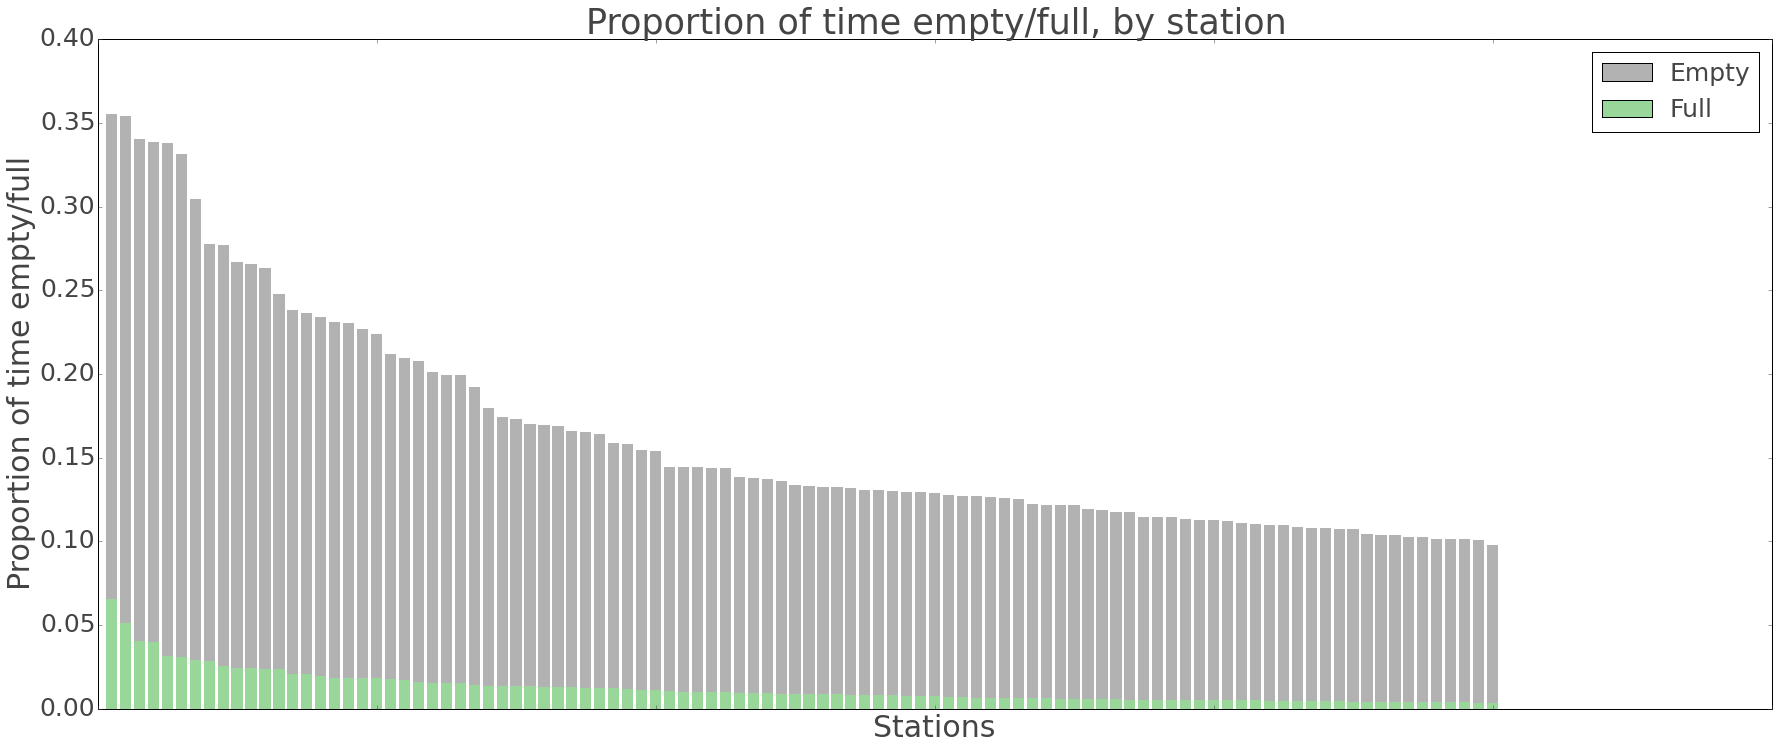

In [216]:
# Running the code from Hubway
statusintervals['fullness']=statusintervals.avail_bikes/statusintervals.tot_docks
FullStatus=statusintervals
FullStatus['EmptyFull']=pd.np.where(FullStatus.fullness==1,'Full',np.where(FullStatus.fullness==0,'Empty','Partial'))
StatusCounts=pd.DataFrame(FullStatus['dock_id'].value_counts()).reset_index()
StatusCounts.columns=['dock_id','StatusCounts']

# Groupby to find out counts of how often each station is empty, full, and partial
EmptyFullFreq=FullStatus.groupby(['dock_id','EmptyFull']).count().reset_index()
EmptyFullFreq=pd.merge(left=EmptyFullFreq,right=StatusCounts,how='left',on='dock_id')

#Eliminate 'partial' rows
EmptyFullFreq=EmptyFullFreq[EmptyFullFreq['EmptyFull']!='Partial']

#Create 'emptyfullfreq' column in DF
EmptyFullFreq['emptyfullfreq']=EmptyFullFreq.fullness/EmptyFullFreq.StatusCounts

#Drop unnecessary columns
EmptyFullFreq=EmptyFullFreq[['dock_id','EmptyFull','emptyfullfreq']]

#Isolate fullness rows, sort, and prepare to plot
FullFreq=EmptyFullFreq[EmptyFullFreq['EmptyFull']=='Full']
FullFreq=FullFreq.sort('emptyfullfreq', ascending=False)
SortedStationsFull=FullFreq.dock_id.tolist()
SortedStationsFull=[str(x) for x in SortedStationsFull]

#Isolate emptiness rows, sort, and prepare to plot
EmptyFreq=EmptyFullFreq[EmptyFullFreq['EmptyFull']=='Empty']
EmptyFreq=EmptyFreq.sort('emptyfullfreq', ascending=False)
SortedStationsEmpty=EmptyFreq.dock_id.tolist()
SortedStationsEmpty=[str(x) for x in SortedStationsEmpty]

# Using only 100 stations for plotting needs
EmptyFreq100 = EmptyFreq[:100]
FullFreq100 = FullFreq[:100]

#Plot emptiness frequency
plt.figure(figsize=(30,12))
plt.xticks(visible=False)
plt.bar(np.arange(1,len(EmptyFreq100)+1),EmptyFreq100.emptyfullfreq,align='center',color=dark_colors[1], alpha=1)
plt.xticks(visible=False)
plt.tick_params(axis='both', which='major', labelsize=25);

#Plot fullness frequency
plt.bar(np.arange(1,len(FullFreq100)+1),FullFreq100.emptyfullfreq,align='center',color=dark_colors[0], alpha=1)
plt.xticks(visible=False)
plt.xlabel('Stations', size=30)
plt.ylabel('Proportion of time empty/full' ,size=30)
plt.title('Proportion of time empty/full, by station',size=35)
plt.legend(['Empty', 'Full'], fontsize=25)

### AM-PM Peak Analysis

In [217]:
###Prepare dataset
statusintervals['fullness']=statusintervals.avail_bikes/statusintervals.tot_docks
FullStatus=statusintervals[statusintervals.weekday<5]
FullStatus['EmptyFull']=pd.np.where(FullStatus.fullness==1,'Full',np.where(FullStatus.fullness==0,'Empty','Partial'))

#Eliminate 'partial' rows
FullStatus2=FullStatus[FullStatus['EmptyFull']!='Partial']

#Create full/empty frequency DFs for AM and PM peaks
PM_PeakFullStatus=FullStatus2[(FullStatus2['hour']>=16) & (FullStatus2['hour']<=18)]
AM_PeakFullStatus=FullStatus2[(FullStatus2['hour']>=8) & (FullStatus2['hour']<=10)]

PM_StatusCounts=FullStatus[(FullStatus['hour']>=16) & (FullStatus['hour']<=18)]
AM_StatusCounts=FullStatus[(FullStatus['hour']>=8) & (FullStatus['hour']<=10)]
PM_StatusCounts=pd.DataFrame(PM_StatusCounts['dock_id'].value_counts()).reset_index()
AM_StatusCounts=pd.DataFrame(AM_StatusCounts['dock_id'].value_counts()).reset_index()
AM_StatusCounts.columns=['dock_id','StatusCounts']
PM_StatusCounts.columns=['dock_id','StatusCounts']

# Groupby to find out counts of how often each station is empty, full, during peaks
AM_PeakFullStatus=AM_PeakFullStatus.groupby(['dock_id','EmptyFull']).count().reset_index()
AM_PeakFullStatus=pd.merge(left=AM_PeakFullStatus,right=AM_StatusCounts,how='left',on='dock_id')
PM_PeakFullStatus=PM_PeakFullStatus.groupby(['dock_id','EmptyFull']).count().reset_index()
PM_PeakFullStatus=pd.merge(left=PM_PeakFullStatus,right=PM_StatusCounts,how='left',on='dock_id')

#Create 'emptyfullfreq' column in DFs
AM_PeakFullStatus['emptyfullfreq']=AM_PeakFullStatus.fullness/AM_PeakFullStatus.StatusCounts
PM_PeakFullStatus['emptyfullfreq']=PM_PeakFullStatus.fullness/PM_PeakFullStatus.StatusCounts

#Drop unnecessary columns
AM_PeakFullStatus=AM_PeakFullStatus[['dock_id','EmptyFull','emptyfullfreq']]
PM_PeakFullStatus=PM_PeakFullStatus[['dock_id','EmptyFull','emptyfullfreq']]

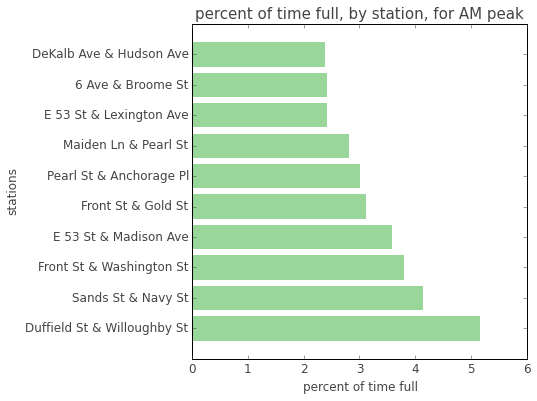

In [222]:
#Isolate fullness rows, sort, and prepare to plot
AM_FullFreq=AM_PeakFullStatus[AM_PeakFullStatus['EmptyFull']=='Full']
AM_FullFreq=AM_FullFreq.sort('emptyfullfreq', ascending=False)
AM_SortedStationsFull=AM_FullFreq.dock_id.tolist()
AM_SortedStationsFull=[str(x) for x in AM_SortedStationsFull]

#List of worst stations
AM_FullID=[int(x) for x in AM_SortedStationsFull]
AM_Full_top=pd.DataFrame(AM_FullID)
AM_Full_top.columns=['dock_id']
#AM_Full_top=pd.merge(AM_Full_top,stations,on='dock_id',how='left')

# Subset only for 10
#AM_FullFreq50 = AM_FullFreq[:10]
#AM_Full_top50 = AM_Full_top[:10]

#Plot fullness frequency
plt.figure(figsize=(6,6))
plt.barh(np.arange(1,len(AM_FullFreq50)+1),[float(item)*100 for item in AM_FullFreq50.emptyfullfreq],align='center',color=dark_colors[0])
plt.yticks(range(1,len(AM_FullFreq50.emptyfullfreq)+1),AM_Full_top50.dock_name,size='small')
plt.ylabel('stations',size=12)
plt.xlabel('percent of time full',size=12)
plt.title('percent of time full, by station, for AM peak', size=15)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.ylim([0,len(AM_FullFreq50.emptyfullfreq)+1])
plt.show()

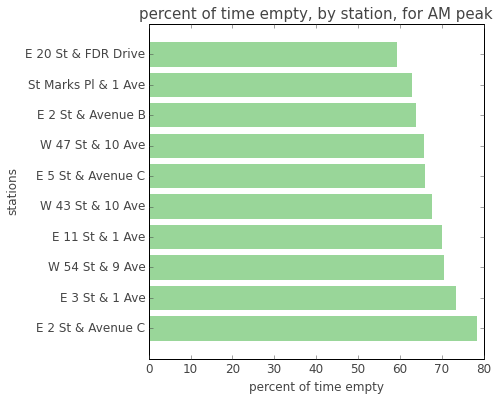

In [224]:
#Isolate fullness rows, sort, and prepare to plot
AM_EmptyFreq=AM_PeakFullStatus[AM_PeakFullStatus['EmptyFull']=='Empty']
AM_EmptyFreq=AM_EmptyFreq.sort('emptyfullfreq', ascending=False)
AM_SortedStationsEmpty=AM_EmptyFreq.dock_id.tolist()
AM_SortedStationsEmpty=[str(x) for x in AM_SortedStationsEmpty]

#List of worst stations
AM_EmptyID=[int(x) for x in AM_SortedStationsEmpty]
AM_Empty_top=pd.DataFrame(AM_EmptyID)
AM_Empty_top.columns=['dock_id']
#AM_Empty_top=pd.merge(AM_Empty_top,stations,on='dock_id',how='left')

# Subset only for 50
#AM_EmptyFreq50 = AM_EmptyFreq[:10]
#AM_Empty_top50 = AM_Empty_top[:10]

#Plot fullness frequency
plt.figure(figsize=(6,6))
plt.barh(np.arange(1,len(AM_EmptyFreq50)+1),[float(item)*100 for item in AM_EmptyFreq50.emptyfullfreq],align='center',color=dark_colors[0])
plt.yticks(range(1,len(AM_EmptyFreq50.emptyfullfreq)+1),AM_Empty_top50.dock_name,size='small')
plt.ylabel('stations',size=12)
plt.xlabel('percent of time empty',size=12)
plt.title('percent of time empty, by station, for AM peak', size=15)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.ylim([0,len(AM_EmptyFreq50.emptyfullfreq)+1])
plt.show()

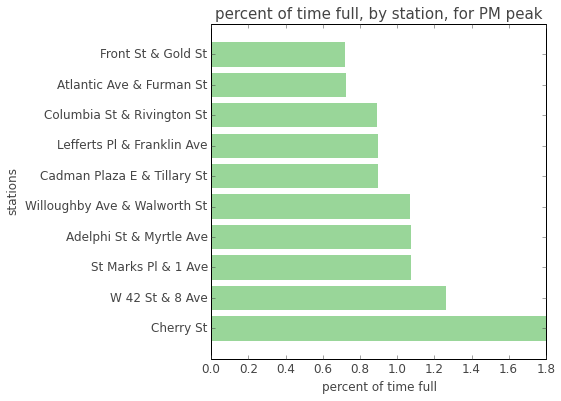

In [227]:
#Isolate fullness rows, sort, and prepare to plot
PM_FullFreq=PM_PeakFullStatus[PM_PeakFullStatus['EmptyFull']=='Full']
PM_FullFreq=PM_FullFreq.sort('emptyfullfreq', ascending=False)
PM_SortedStationsFull=PM_FullFreq.dock_id.tolist()
PM_SortedStationsFull=[str(x) for x in PM_SortedStationsFull]

#List of worst stations
PM_FullID=[int(x) for x in PM_SortedStationsFull]
PM_Full_top=pd.DataFrame(PM_FullID)
PM_Full_top.columns=['dock_id']
#PM_Full_top=pd.merge(PM_Full_top,stations,on='dock_id',how='left')

# Subset only for 50
#PM_FullFreq50 = PM_FullFreq[:10]
#PM_Full_top50 = PM_Full_top[:10]

#Plot fullness frequency
plt.figure(figsize=(6,6))
plt.barh(np.arange(1,len(PM_FullFreq50)+1),[float(item)*100 for item in PM_FullFreq50.emptyfullfreq],align='center',color=dark_colors[0])
plt.yticks(range(1,len(PM_FullFreq50.emptyfullfreq)+1),PM_Full_top50.dock_name,size='small')
plt.ylabel('stations',size=12)
plt.xlabel('percent of time full',size=12)
plt.title('percent of time full, by station, for PM peak', size=15)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.ylim([0,len(PM_FullFreq50.emptyfullfreq)+1])
plt.show()

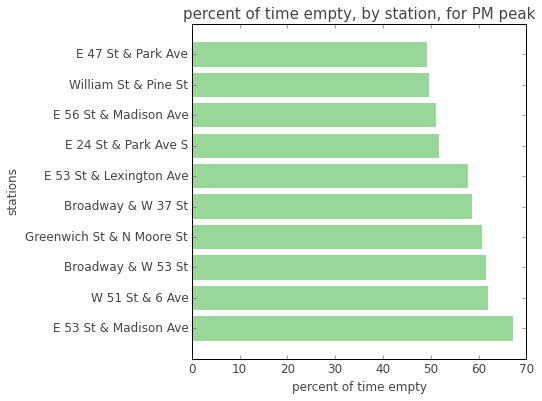

In [228]:
#Isolate fullness rows, sort, and prepare to plot
PM_EmptyFreq=PM_PeakFullStatus[PM_PeakFullStatus['EmptyFull']=='Empty']
PM_EmptyFreq=PM_EmptyFreq.sort('emptyfullfreq', ascending=False)
PM_SortedStationsEmpty=PM_EmptyFreq.dock_id.tolist()
PM_SortedStationsEmpty=[str(x) for x in PM_SortedStationsEmpty]

#List of worst stations
PM_EmptyID=[int(x) for x in PM_SortedStationsEmpty]
PM_Empty_top=pd.DataFrame(PM_EmptyID)
PM_Empty_top.columns=['dock_id']
#PM_Empty_top=pd.merge(PM_Empty_top,stations,on='dock_id',how='left')

# Subset only for 10
#PM_EmptyFreq50 = PM_EmptyFreq[:10]
#PM_Empty_top50 = PM_Empty_top[:10]

#Plot fullness frequency
plt.figure(figsize=(6,6))
plt.barh(np.arange(1,len(PM_EmptyFreq50)+1),[float(item)*100 for item in PM_EmptyFreq50.emptyfullfreq],align='center',color=dark_colors[0])
plt.yticks(range(1,len(PM_EmptyFreq50.emptyfullfreq)+1),PM_Empty_top50.dock_name,size='small')
plt.ylabel('stations',size=12)
plt.xlabel('percent of time empty',size=12)
plt.title('percent of time empty, by station, for PM peak', size=15)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.ylim([0,len(PM_EmptyFreq50.emptyfullfreq)+1])
plt.show()

### Clustering stations fullness profiles
In order to understand the causes and characteristics of station fullness and emptiness, we examine the usage patterns of different stations. We expect certain stations are used in similar ways by users based on their location and the type of neighborhood they serve. For example, stations located in the urban core are likely to fill-up as the morning commuters converge down-town to work and to empty in the evening as they return home. While each station is unique, it is useful to consider such similarity in usage patterns to understand the dynamics of network imbalances.

The evolution of station fullness over time of day is a useful metric to extract such similarities. Fullness profile is obtained by averaging the ratio of number bicycles over station capacity for each station over all days in the 2012 season. Fullness ratio for a station $i$ at interval $t$ is computed as follows :
$ f_{i,t}= \frac{1}{n}\sum_{i=1}^{n} \frac{bikes_{i,t}}{capacity_{i,t}}$
where $n$ represents the number of week days in the 2012 season.

From these, stations are described by 288 features representing fullness for each 5-minute intervals of a typical weekday.
We then compute a linear transformation of these features from SVD to reduce the dimensionality of this profile. 
From the resulting transformation we perform a simple K-Means cluster analysis to group together stations with similar fullness/emptiness profiles.

In [88]:
statusintervals[['avail_bikes','fullness', 'tot_docks']].describe()

,avail_bikes,fullness,tot_docks
count,1511932.000000,1511932.000000,1511932.000000
mean,12.025994,0.364835,34.026373
std,10.797094,0.301029,9.786080
min,0.000000,0.000000,9.000000
25%,3.000000,0.085714,27.000000
50%,9.000000,0.303030,32.000000
75%,19.000000,0.612245,39.000000
max,62.000000,1.000000,62.000000


In [89]:
# Ignoring the docks with 0 values and are less than avail_bikes values
# statusintervals1=dockfinal3[(statusintervals.tot_docks>0)]
# statusintervals1.shape
# & (statusintervals.tot_docks>=statusintervals.avail_bikes)]

In [90]:
# Making a copy of the data
statusintervals1 = statusintervals.copy()

# Compute the fullness ratio as the number of bikes over the capacity for each interval
statusintervals1['fullness_ratio']=statusintervals1.avail_bikes/statusintervals1.tot_docks

# Differentiate Between weekdays and week-end days
#statusintervals1['week']=statusintervals1.weekday < 5

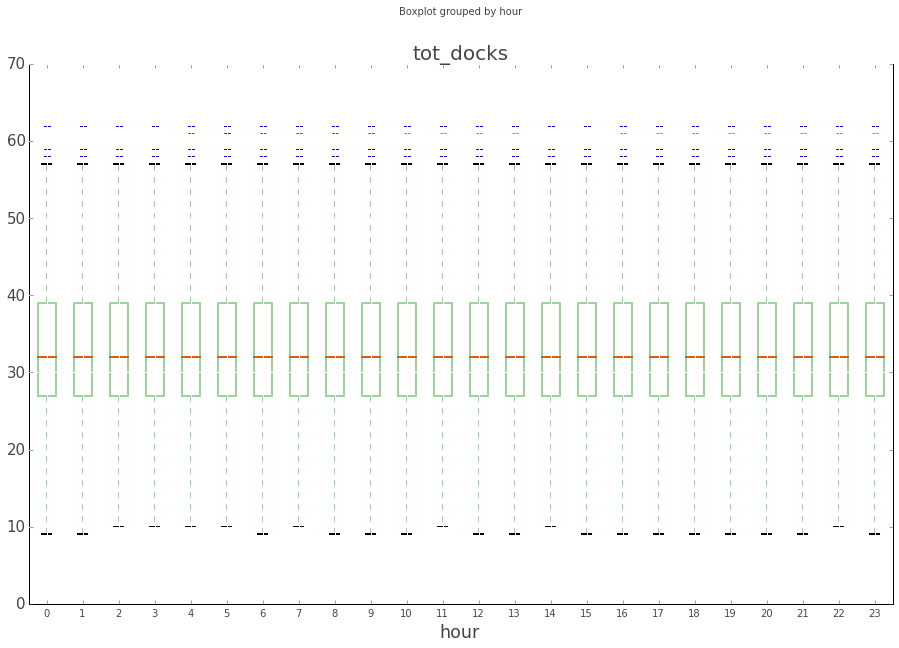

In [231]:
statusintervals1.boxplot(column='tot_docks', by='hour', figsize=(15,10))

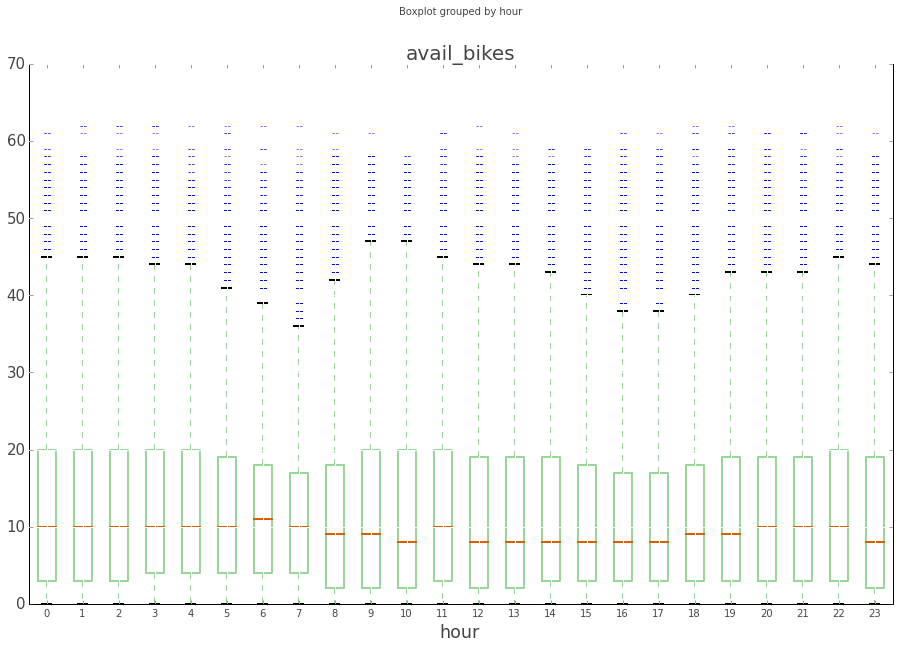

In [232]:
statusintervals1.boxplot(column='avail_bikes', by='hour', figsize=(15,10))

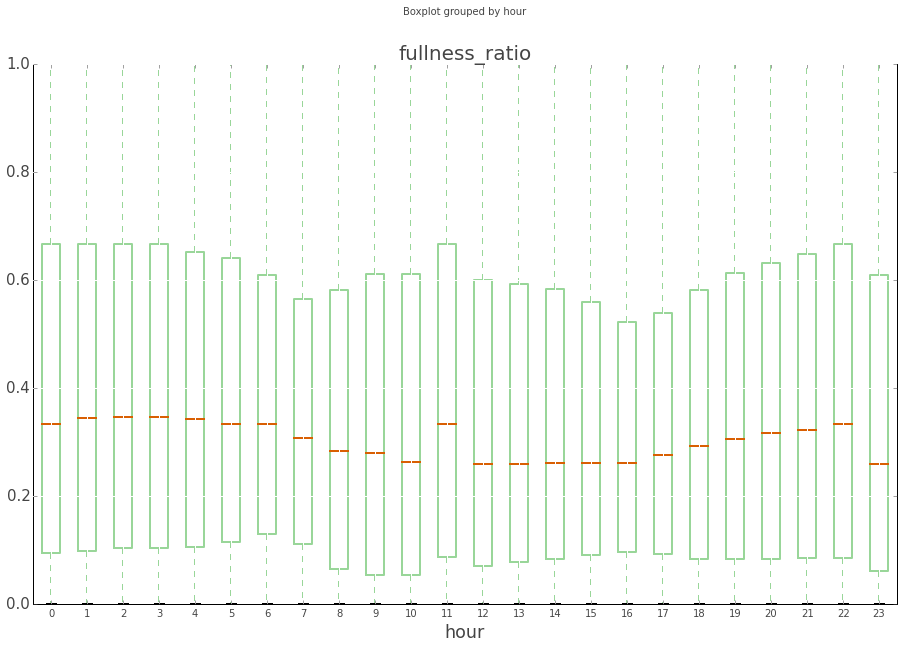

In [233]:
statusintervals1.boxplot(column='fullness_ratio', by='hour', figsize=(15,10))

In [107]:
statusintervals1[statusintervals1['hour']==11]['fullness_ratio'].mean()

0.39181872281347524

In [113]:
statusintervals1[statusintervals1['hour']==11].groupby('dock_id')['fullness_ratio'].mean().order(ascending=False)[:10]

dock_id
301    0.751418
439    0.751360
515    0.745792
509    0.745520
302    0.738832
326    0.738342
445    0.735502
346    0.734709
393    0.726109
438    0.722937
Name: fullness_ratio, dtype: float64

In [126]:
print(statusintervals1.loc[(statusintervals1['dock_id']==72) & (statusintervals['hour']==10), ['avail_bikes']].mean())
print(statusintervals1.loc[(statusintervals1['dock_id']==72) & (statusintervals['hour']==10), ['tot_docks']].mean())
print(statusintervals1.loc[(statusintervals1['dock_id']==72) & (statusintervals['hour']==10), ['fullness_ratio']].mean())
print(statusintervals1.loc[(statusintervals1['dock_id']==72) & (statusintervals['hour']==11), ['avail_bikes']].mean())
print(statusintervals1.loc[(statusintervals1['dock_id']==72) & (statusintervals['hour']==11), ['tot_docks']].mean())
print(statusintervals1.loc[(statusintervals1['dock_id']==72) & (statusintervals['hour']==11), ['fullness_ratio']].mean())
print(statusintervals1.loc[(statusintervals1['dock_id']==72) & (statusintervals['hour']==12), ['avail_bikes']].mean())
print(statusintervals1.loc[(statusintervals1['dock_id']==72) & (statusintervals['hour']==12), ['tot_docks']].mean())
print(statusintervals1.loc[(statusintervals1['dock_id']==72) & (statusintervals['hour']==12), ['fullness_ratio']].mean())

avail_bikes    8.654902
dtype: float64
tot_docks    38.498039
dtype: float64
fullness_ratio    0.225593
dtype: float64
avail_bikes    17.690763
dtype: float64
tot_docks    38.485944
dtype: float64
fullness_ratio    0.458956
dtype: float64
avail_bikes    9.035019
dtype: float64
tot_docks    38.455253
dtype: float64
fullness_ratio    0.23639
dtype: float64


In [91]:
# Group by station and interval of the day for week days and pivot into a matrix
#fullness = statusintervals1.loc[statusintervals1.week == True].groupby(['dock_id','hour'])['fullness_ratio'].mean()
fullness = statusintervals1.groupby(['dock_id','hour'])['fullness_ratio'].mean()

In [92]:
fullness = fullness.reset_index().pivot(index='dock_id', columns='hour', values='fullness_ratio')
#fullness.info()

In [128]:
fullness.ix[:, 20:24][:10]

hour,20,21,22,23
dock_id,,,,
72,0.385066,0.413701,0.439225,0.235599
79,0.158508,0.145385,0.138706,0.469605
82,0.338831,0.349253,0.365660,0.243551
83,0.407108,0.399549,0.391589,0.350958
119,0.471325,0.479516,0.484936,0.370178
120,0.433358,0.464442,0.489844,0.227228
127,0.584987,0.605955,0.615360,0.346347
137,0.114485,0.102899,0.096513,0.570774
143,0.482889,0.508488,0.525289,0.251847


In [95]:
# Making it as cluster
clusterData = fullness.as_matrix()
print(clusterData.shape)
print(clusterData.shape[0])

(253, 24)
253


In [130]:
# Normalizing the data
vals = ((clusterData.T - clusterData.mean(1))/clusterData.std(1)).T
print(vals.shape)

# Using number of clusters as 3
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3)
km.fit(vals)
print(km)
kmlabels = km.labels_
kmcenters = km.cluster_centers_

(253, 24)
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


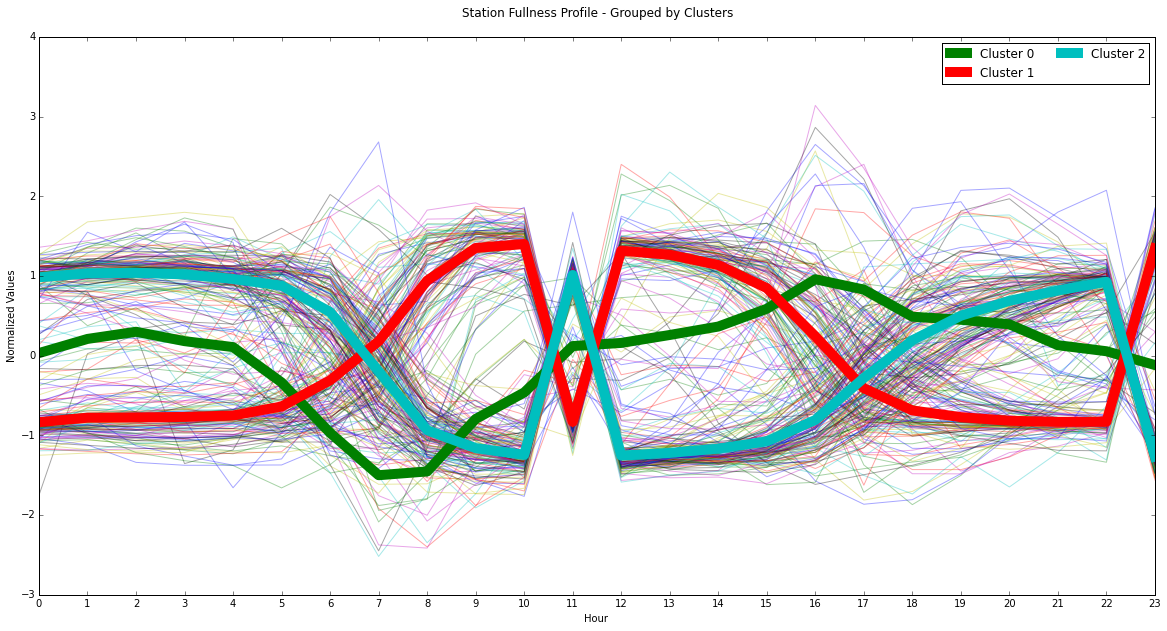

In [131]:
# Plotting all the values and respective centroid values for each of the cluster trends
figure, ax = plt.subplots(figsize=(20,10))
num_clusters = len(kmcenters)
    
for i in range(num_clusters):
    ax.plot(vals[kmlabels == i].transpose(), alpha=.35)

for i in range(num_clusters):
    ax.plot(kmcenters[i], linewidth=10, label='Cluster %s' % i)

ax.set_xlim([0,23])
ax.set_title('Station Fullness Profile - Grouped by Clusters \n')
ax.set_xticks(np.arange(24))
ax.set_xticklabels(0 + np.arange(24))
ax.set_xlabel('Hour')
ax.set_ylabel('Normalized Values')
ax.legend(ncol=2)

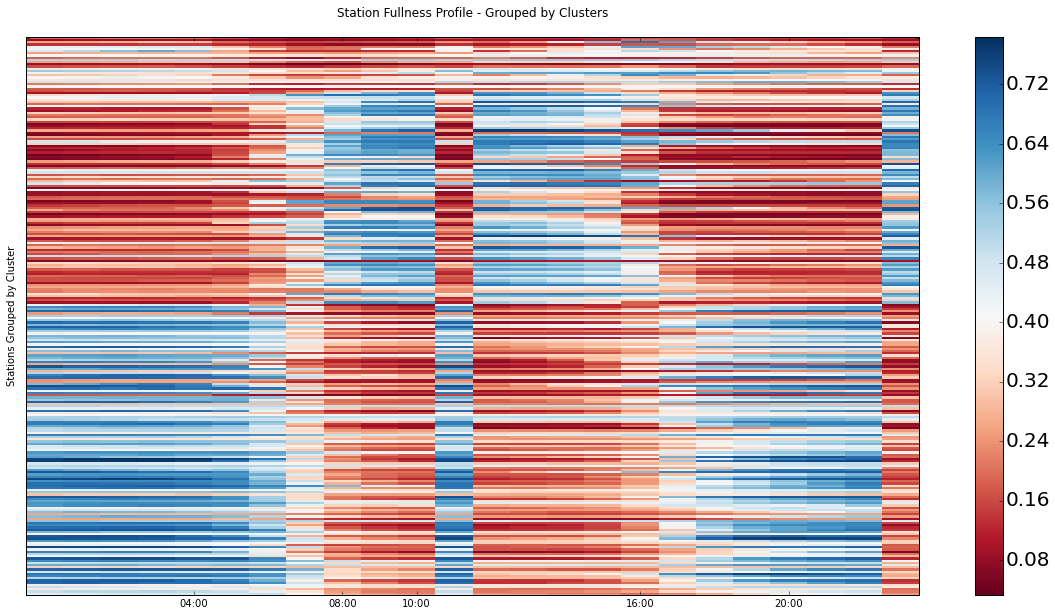

In [132]:
# Adding cluster labels to the data
fullness['cluster_id'] = kmlabels
fullness_sorted = fullness.sort(['cluster_id'])

#Plot Image of All Fullness profiles ordered by clusterid clustering
plt.figure(figsize=(20,10))
imgplot = plt.imshow(fullness_sorted.ix[:,0:-1],aspect='auto',interpolation='none')
imgplot.set_cmap('RdBu')
plt.yticks([0],[''])
plt.ylabel('Stations Grouped by Cluster')
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20) 
plt.xticks([4,8,10,16,20], ['04:00', '08:00', '10:00','16:00','20:00'])
plt.title('Station Fullness Profile - Grouped by Clusters \n');

### CartoDB Visualization of Clusters

## To be done for presentation

In [134]:
fullness.columns

Index([           0,            1,            2,            3,            4,
                  5,            6,            7,            8,            9,
                 10,           11,           12,           13,           14,
                 15,           16,           17,           18,           19,
                 20,           21,           22,           23, 'cluster_id'],
      dtype='object', name='hour')

In [135]:
fullness['cluster_id'].unique()

array([2, 1, 0])

In [136]:
fullness.to_csv("cluster_output.csv")

### PREDICTION

In this section, we explored using classification, bayesian, and regression techniques models predict the occurances of empty or full Hubway stations.

### 3.1 Prediction Dataframe

Here we prepare key predictive variables to be used by each model, including:
* historical average arrivals and departures by station, weekday, and interval
* lagged station status variables for various prediction windows
* emptyness/fullness ratio and dummy variables
* weather related information

Lastly, we use a 2/3:1/3 training:test split to produce dataframes to train and test our models.


In [153]:
#statusintervals1=statusintervals[(statusintervals.tot_docks>0) & (statusintervals.tot_docks>=statusintervals.avail_bikes)]
#print statusintervals1.shape
#statusintervals1.head()

In [154]:
###--- Weather---###
#reg_df= pd.merge(statusintervals, weather[['daydate', 'hour', 'precip', 'temp']],
#                 how='left', on=['daydate', 'hour'])

reg_df=statusintervals1

###--- Historical Averages ---###
# Averages for the same stationid, weekday, time of day (1 hour interval)
hist_avg = reg_df.groupby(['dock_id','weekday','hour'])[['bike_arrivals', 'bike_departures']].mean()
hist_avg.columns = ['hist_arr', 'hist_dep']
reg_df=reg_df.merge(hist_avg, how='left', left_on=['dock_id','weekday','hour'], right_index=True)
reg_df.head()

,interv,dock_id,interv_date,hour,month,date,avail_docks,tot_docks,avail_bikes,weekday,avail_bikes_lagged,tot_docks_lagged,bike_arrivals,delta_capacity,bike_departures,fullness,EmptyFull,fullness_ratio,hist_arr,hist_dep
0,2015-03-01 00:00:00,72,2015-03-01,0,3,15-03-01,30,38,7,6,NaN,NaN,0,NaN,0,0.184211,Partial,0.184211,6.388889,1.138889
253,2015-03-01 01:00:00,72,2015-03-01,1,3,15-03-01,30,38,8,6,7,38,1,0,0,0.210526,Partial,0.210526,0.666667,0.861111
506,2015-03-01 02:00:00,72,2015-03-01,2,3,15-03-01,30,38,8,6,8,38,0,0,0,0.210526,Partial,0.210526,0.314286,0.142857
759,2015-03-01 03:00:00,72,2015-03-01,3,3,15-03-01,30,38,8,6,8,38,0,0,0,0.210526,Partial,0.210526,0.142857,0.028571
1012,2015-03-01 04:00:00,72,2015-03-01,4,3,15-03-01,30,38,8,6,8,38,0,0,0,0.210526,Partial,0.210526,0.314286,0.314286


In [155]:
###--- "Real-time" Previous Station Status ---###
# define the prediction windows and lags to be considered ##
pred_windows = np.array([1])
print(pred_windows)
nbr_prev = 3
print(nbr_prev)
lags = np.arange(1, 5, 1)
print(lags)

[1]
3
[1 2 3 4]


In [156]:
# Create Lag Columns in terms of one hour intervals
for lag in lags:
    reg_df['arr_lag'+str(lag)]=reg_df.groupby(['dock_id'])['bike_arrivals'].shift(lag)
    reg_df['dep_lag'+str(lag)]=reg_df.groupby(['dock_id'])['bike_departures'].shift(lag)
    
reg_df.shape

(1511932, 28)

In [157]:
reg_df.columns

Index(['interv', 'dock_id', 'interv_date', 'hour', 'month', 'date',
       'avail_docks', 'tot_docks', 'avail_bikes', 'weekday',
       'avail_bikes_lagged', 'tot_docks_lagged', 'bike_arrivals',
       'delta_capacity', 'bike_departures', 'fullness', 'EmptyFull',
       'fullness_ratio', 'hist_arr', 'hist_dep', 'arr_lag1', 'dep_lag1',
       'arr_lag2', 'dep_lag2', 'arr_lag3', 'dep_lag3', 'arr_lag4', 'dep_lag4'],
      dtype='object')

In [158]:
# Compute "Real-Time" information from recent past    
for window in pred_windows:
    i= window
    # Take the mean of nbr_prev(e.g. 3 previous periods) for each prediction window 
    reg_df['avg_arr_'+str(window)]= reg_df[['arr_lag'+str(lag) for lag in lags[i:i+nbr_prev]]].mean(axis=1)
    reg_df['avg_dep_'+str(window)]= reg_df[['dep_lag'+str(lag) for lag in lags[i:i+nbr_prev]]].mean(axis=1)
    
    #compute the lags for each prediction window
    reg_df['lagbikes'+str(window)]=reg_df.groupby(['dock_id'])['avail_bikes'].shift(window)
    reg_df['lagcap'+str(window)]=reg_df.groupby(['dock_id'])['tot_docks'].shift(window)
    reg_df['isempty'+str(window)]=(reg_df['lagbikes'+str(window)]==0)*1.0
    reg_df['isfull'+str(window)]=(reg_df['lagbikes'+str(window)]==reg_df['lagcap'+str(window)])*1.0    
    
reg_df.drop(['arr_lag'+str(lag) for lag in lags], axis=1, inplace=True)
reg_df.drop(['dep_lag'+str(lag) for lag in lags], axis=1, inplace=True)

In [159]:
reg_df.columns

Index(['interv', 'dock_id', 'interv_date', 'hour', 'month', 'date',
       'avail_docks', 'tot_docks', 'avail_bikes', 'weekday',
       'avail_bikes_lagged', 'tot_docks_lagged', 'bike_arrivals',
       'delta_capacity', 'bike_departures', 'fullness', 'EmptyFull',
       'fullness_ratio', 'hist_arr', 'hist_dep', 'avg_arr_1', 'avg_dep_1',
       'lagbikes1', 'lagcap1', 'isempty1', 'isfull1'],
      dtype='object')

In [160]:
###--- Label Variable ---###
reg_df['isfull']= reg_df['tot_docks'] == reg_df['avail_bikes']
reg_df['isempty']= reg_df['avail_bikes'] == 0
reg_df['fullness']= reg_df['avail_bikes']/reg_df['tot_docks']
reg_df['fullness1']= reg_df['lagbikes1']/reg_df['lagcap1']

# Exclude edge cases on first day
#reg_df= reg_df.loc[(reg_df.interv > datetime.datetime(2012,5,1,1))]

# Display Head of reg_df 
#pd.set_option('max_columns', 100)
reg_df.head()

,interv,dock_id,interv_date,hour,month,date,avail_docks,tot_docks,avail_bikes,weekday,...,hist_dep,avg_arr_1,avg_dep_1,lagbikes1,lagcap1,isempty1,isfull1,isfull,isempty,fullness1
0,2015-03-01 00:00:00,72,2015-03-01,0,3,15-03-01,30,38,7,6,...,1.138889,NaN,NaN,NaN,NaN,0,0,False,False,NaN
253,2015-03-01 01:00:00,72,2015-03-01,1,3,15-03-01,30,38,8,6,...,0.861111,NaN,NaN,7,38,0,0,False,False,0.184211
506,2015-03-01 02:00:00,72,2015-03-01,2,3,15-03-01,30,38,8,6,...,0.142857,0.000000,0,8,38,0,0,False,False,0.210526
759,2015-03-01 03:00:00,72,2015-03-01,3,3,15-03-01,30,38,8,6,...,0.028571,0.500000,0,8,38,0,0,False,False,0.210526
1012,2015-03-01 04:00:00,72,2015-03-01,4,3,15-03-01,30,38,8,6,...,0.314286,0.333333,0,8,38,0,0,False,False,0.210526


In [161]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1511932 entries, 0 to 1669799
Data columns (total 29 columns):
interv                1511932 non-null datetime64[ns]
dock_id               1511932 non-null int64
interv_date           1511932 non-null object
hour                  1511932 non-null int32
month                 1511932 non-null int32
date                  1511932 non-null object
avail_docks           1511932 non-null int64
tot_docks             1511932 non-null int64
avail_bikes           1511932 non-null int64
weekday               1511932 non-null int64
avail_bikes_lagged    1511679 non-null float64
tot_docks_lagged      1511679 non-null float64
bike_arrivals         1511932 non-null float64
delta_capacity        1511679 non-null float64
bike_departures       1511932 non-null float64
fullness              1511932 non-null float64
EmptyFull             1511932 non-null object
fullness_ratio        1511932 non-null float64
hist_arr              1511932 non-null float64
hist

In [162]:
reg_df.isnull().sum()

interv                  0
dock_id                 0
interv_date             0
hour                    0
month                   0
date                    0
avail_docks             0
tot_docks               0
avail_bikes             0
weekday                 0
avail_bikes_lagged    253
tot_docks_lagged      253
bike_arrivals           0
delta_capacity        253
bike_departures         0
fullness                0
EmptyFull               0
fullness_ratio          0
hist_arr                0
hist_dep                0
avg_arr_1             506
avg_dep_1             506
lagbikes1             253
lagcap1               253
isempty1                0
isfull1                 0
isfull                  0
isempty                 0
fullness1             253
dtype: int64

In [163]:
# Drop missing values
reg_df = reg_df.dropna()
reg_df.shape

(1511426, 29)

### Merge with weather data

In [164]:
weather.head()

,index,temp,datetime,hour,month,daydate,weekday
0,0,25.7,2015-03-01 00:00:00,0,3,2015-03-01,6
1,1,24.8,2015-03-01 01:00:00,1,3,2015-03-01,6
2,2,22.8,2015-03-01 02:00:00,2,3,2015-03-01,6
3,3,21.1,2015-03-01 03:00:00,3,3,2015-03-01,6
4,4,20.1,2015-03-01 04:00:00,4,3,2015-03-01,6


In [166]:
weather.rename(columns={'daydate':'date'}, inplace=True)

In [170]:
weather['date'].str[2:10][:10]

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: date, dtype: float64

In [171]:
weather['date'] = pd.DatetimeIndex(weather['date']).date.astype(str)
weather['date'] = weather['date'].str[2:10]
weather.head()

,index,temp,datetime,hour,month,date,weekday
0,0,25.7,2015-03-01 00:00:00,0,3,15-03-01,6
1,1,24.8,2015-03-01 01:00:00,1,3,15-03-01,6
2,2,22.8,2015-03-01 02:00:00,2,3,15-03-01,6
3,3,21.1,2015-03-01 03:00:00,3,3,15-03-01,6
4,4,20.1,2015-03-01 04:00:00,4,3,15-03-01,6


In [172]:
reg_df.columns

Index(['interv', 'dock_id', 'interv_date', 'hour', 'month', 'date',
       'avail_docks', 'tot_docks', 'avail_bikes', 'weekday',
       'avail_bikes_lagged', 'tot_docks_lagged', 'bike_arrivals',
       'delta_capacity', 'bike_departures', 'fullness', 'EmptyFull',
       'fullness_ratio', 'hist_arr', 'hist_dep', 'avg_arr_1', 'avg_dep_1',
       'lagbikes1', 'lagcap1', 'isempty1', 'isfull1', 'isfull', 'isempty',
       'fullness1'],
      dtype='object')

In [173]:
reg_df[['date', 'hour']].head()

,date,hour
506,15-03-01,2
759,15-03-01,3
1012,15-03-01,4
1265,15-03-01,5
1518,15-03-01,6


In [174]:
# Merging weather data
reg_df_final = pd.merge(reg_df, weather, on=['date','hour'], how='left')
reg_df_final.shape

(1511426, 34)

In [175]:
# Check for missing values
reg_df_final.isnull().sum()

interv                0
dock_id               0
interv_date           0
hour                  0
month_x               0
date                  0
avail_docks           0
tot_docks             0
avail_bikes           0
weekday_x             0
avail_bikes_lagged    0
tot_docks_lagged      0
bike_arrivals         0
delta_capacity        0
bike_departures       0
fullness              0
EmptyFull             0
fullness_ratio        0
hist_arr              0
hist_dep              0
avg_arr_1             0
avg_dep_1             0
lagbikes1             0
lagcap1               0
isempty1              0
isfull1               0
isfull                0
isempty               0
fullness1             0
index                 0
temp                  0
datetime              0
month_y               0
weekday_y             0
dtype: int64

In [182]:
#split training and test data by 2/3, 1/3, respectively
df = pd.DataFrame(np.random.randn(len(reg_df), 1))
msk = np.random.rand(len(df)) < 0.6666
reg_df_train = reg_df_final[msk]
reg_df_test = reg_df_final[~msk]

# Drop original Dataframe for memory
# del reg_df
print(len(reg_df_train))
print(len(reg_df_test))

1006779
504647


## Classifiers for Empty Stations

### Random Forest Classifier

In [189]:
## Empty Station-Intervals  Prediction
print(reg_df_train.shape)

# Define Train dataframe for 1 hour prediction window
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness1'])) & (~pd.isnull(reg_df_train['hist_arr']))]
train.shape

(1006779, 34)


(1006779, 34)

In [201]:
# Define Number of Folds, and Nbr of Trees to Evaluate
#nbr_trees = [10, 20, 30, 50, 100]
#print nbr_trees
#stations = train['dock_id'].unique()
#print len(stations)
#print stations
#nbr_folds = 5
#print nbr_folds

In [200]:
#Preallocate the Crossvalidation DataFrame
#crossval_recall_full=pd.DataFrame(columns = ['dock_id', 'nbr_trees', 'recall'], 
#                             index = range(len(nbr_trees)*len(stations)*nbr_folds),dtype=float)
#crossval_recall_full.dock_id= np.repeat(np.transpose(np.tile(stations, len(nbr_trees))), nbr_folds)
#crossval_recall_full.nbr_trees=np.repeat(nbr_trees, len(stations)*nbr_folds)
#crossval_recall_full.shape

In [192]:
train.columns

Index(['interv', 'dock_id', 'interv_date', 'hour', 'month_x', 'date',
       'avail_docks', 'tot_docks', 'avail_bikes', 'weekday_x',
       'avail_bikes_lagged', 'tot_docks_lagged', 'bike_arrivals',
       'delta_capacity', 'bike_departures', 'fullness', 'EmptyFull',
       'fullness_ratio', 'hist_arr', 'hist_dep', 'avg_arr_1', 'avg_dep_1',
       'lagbikes1', 'lagcap1', 'isempty1', 'isfull1', 'isfull', 'isempty',
       'fullness1', 'index', 'temp', 'datetime', 'month_y', 'weekday_y'],
      dtype='object')

In [194]:
train.isnull().sum()

interv                0
dock_id               0
interv_date           0
hour                  0
month_x               0
date                  0
avail_docks           0
tot_docks             0
avail_bikes           0
weekday_x             0
avail_bikes_lagged    0
tot_docks_lagged      0
bike_arrivals         0
delta_capacity        0
bike_departures       0
fullness              0
EmptyFull             0
fullness_ratio        0
hist_arr              0
hist_dep              0
avg_arr_1             0
avg_dep_1             0
lagbikes1             0
lagcap1               0
isempty1              0
isfull1               0
isfull                0
isempty               0
fullness1             0
index                 0
temp                  0
datetime              0
month_y               0
weekday_y             0
dtype: int64

In [241]:
print(train['isempty'].value_counts())
print(train['isfull'].value_counts())

False    909366
True      97413
dtype: int64
False    1001041
True        5738
dtype: int64


In [199]:
# Empty Station-Intervals Prediction 

# Define Number of Folds, and Nbr of Trees to Evaluate
nbr_trees = [10, 20, 30, 50, 100]
stations = train['dock_id'].unique()
nbr_folds = 5

#Preallocate the Crossvalidation DataFrame for accuracy metric
crossval_accuracy_empty=pd.DataFrame(columns = ['dock_id', 'nbr_trees', 'accuracy'], 
                             index = range(len(nbr_trees)*len(stations)*nbr_folds),dtype=float)
crossval_accuracy_empty.dock_id= np.repeat(np.transpose(np.tile(stations, len(nbr_trees))), nbr_folds)
crossval_accuracy_empty.nbr_trees=np.repeat(nbr_trees, len(stations)*nbr_folds)

#Preallocate the Crossvalidation DataFrame for precision metric
crossval_precision_empty=pd.DataFrame(columns = ['dock_id', 'nbr_trees', 'precision'], 
                             index = range(len(nbr_trees)*len(stations)*nbr_folds),dtype=float)
crossval_precision_empty.dock_id= np.repeat(np.transpose(np.tile(stations, len(nbr_trees))), nbr_folds)
crossval_precision_empty.nbr_trees=np.repeat(nbr_trees, len(stations)*nbr_folds)

#Preallocate the Crossvalidation DataFrame for recall metric
crossval_recall_empty=pd.DataFrame(columns = ['dock_id', 'nbr_trees', 'recall'], 
                             index = range(len(nbr_trees)*len(stations)*nbr_folds),dtype=float)
crossval_recall_empty.dock_id= np.repeat(np.transpose(np.tile(stations, len(nbr_trees))), nbr_folds)
crossval_recall_empty.nbr_trees=np.repeat(nbr_trees, len(stations)*nbr_folds)

# Loop Through Different Number of Trees for each station
for ntree in nbr_trees:
    rdfrst = RandomForestClassifier(n_estimators=(ntree))
    
    #Loop through each station
    for i,station in enumerate(stations):
        X=train.loc[train.dock_id == station,
                    ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
        Y=train.isempty[train.dock_id == station]
        scores_acc = cross_val_score(rdfrst, X,y=Y,cv=nbr_folds, scoring = 'accuracy')
        scores_pre = cross_val_score(rdfrst, X,y=Y,cv=nbr_folds, scoring = 'precision')
        scores_rec = cross_val_score(rdfrst, X,y=Y,cv=nbr_folds, scoring = 'recall')
        
        crossval_accuracy_empty.loc[(crossval_accuracy_empty.dock_id == station) & \
                                  (crossval_accuracy_empty.nbr_trees == ntree), 'accuracy'] =scores_acc
        crossval_precision_empty.loc[(crossval_precision_empty.dock_id == station) & \
                                  (crossval_precision_empty.nbr_trees == ntree), 'precision'] =scores_pre
        crossval_recall_empty.loc[(crossval_recall_empty.dock_id == station) & \
                                  (crossval_recall_empty.nbr_trees == ntree), 'recall'] =scores_rec
        #print "Station: "+str(station)+ " Ntrees: " + str(ntree)
    print("Nbr of Trees: "+str(ntree))

Nbr of Trees: 10
Nbr of Trees: 20
Nbr of Trees: 30
Nbr of Trees: 50
Nbr of Trees: 100


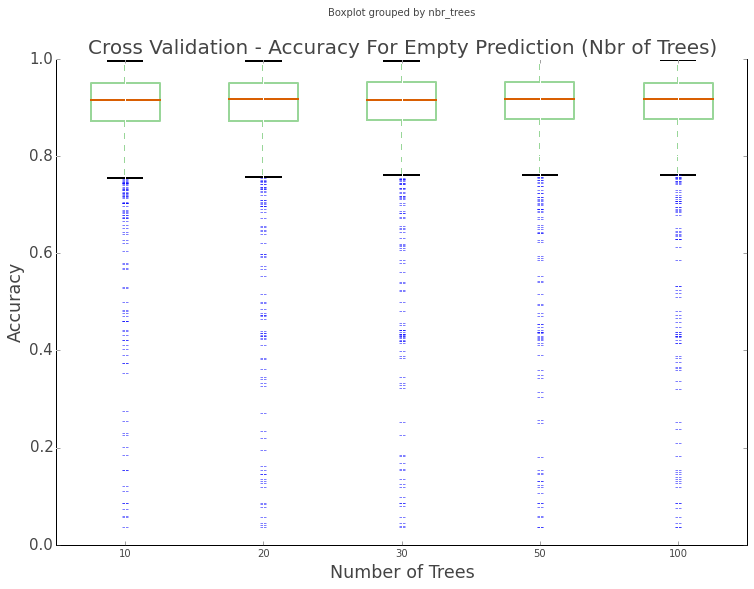

In [207]:
# Plot Distribution of Cross-validation Scores
crossval_accuracy_empty.boxplot(column='accuracy', by='nbr_trees')
plt.title('Cross Validation - Accuracy For Empty Prediction (Nbr of Trees)')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')

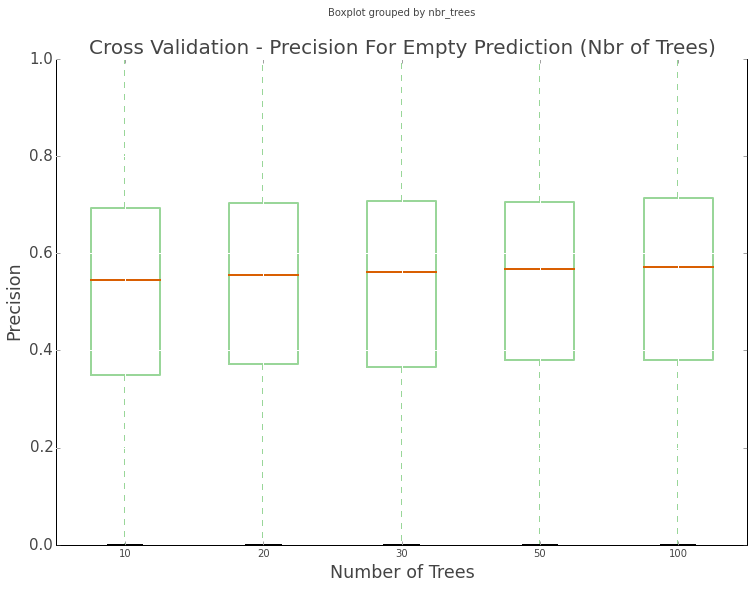

In [208]:
# Plot Distribution of Cross-validation Scores
crossval_precision_empty.boxplot(column='precision', by='nbr_trees')
plt.title('Cross Validation - Precision For Empty Prediction (Nbr of Trees)')
plt.xlabel('Number of Trees')
plt.ylabel('Precision')

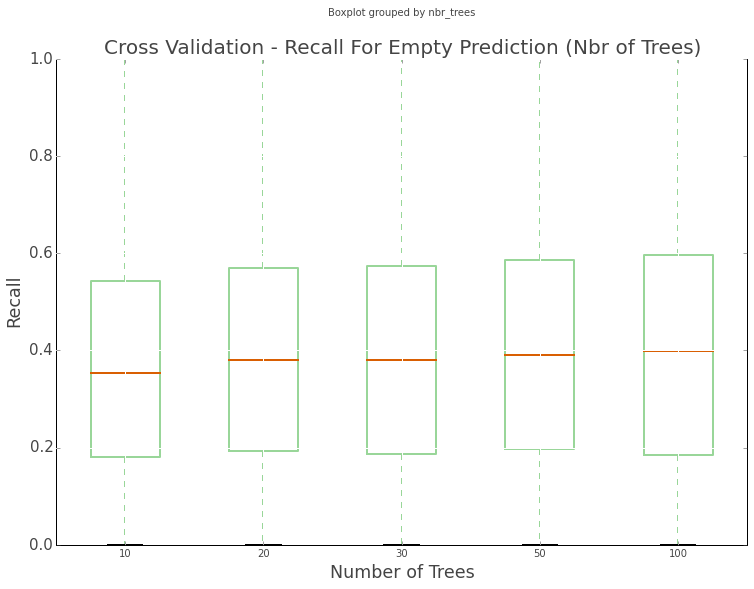

In [209]:
# Plot Distribution of Cross-validation Scores
crossval_recall_empty.boxplot(column='recall', by='nbr_trees')
plt.title('Cross Validation - Recall For Empty Prediction (Nbr of Trees)')
plt.xlabel('Number of Trees')
plt.ylabel('Recall')

### Computing Classifiers Performance

In [230]:
## Test Scores
stations = reg_df_train['dock_id'].unique()

##------------ Empty Station Prediction ------------##
# Preallocate TEST recall empty dataframe & Copy Train and test Dataframe
test_recall_empty = pd.DataFrame(columns = ['dock_id', 'week', 'hour','P_empty','TP_empty'])
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness1'])) & (~pd.isnull(reg_df_train['hist_arr']))]
test= reg_df_test.loc[(~pd.isnull(reg_df_test['fullness1'])) & (~pd.isnull(reg_df_test['hist_arr']))]
test['TP_empty']=np.nan
test['P_empty']=np.nan
test['week']=(test.weekday_x >= 5)*1

# Fit Classifier on Training Data as determined from cross validation and predict test data
rdfrst = RandomForestClassifier(n_estimators=20)     
for i,station in enumerate(stations):
    X_train=train.loc[train.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_train=train.isempty[train.dock_id == station]
    X_test= test.loc[test.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_test= test.isempty[test.dock_id == station]
    
    rdfrst.fit(X_train, Y_train)
    preds = rdfrst.predict(X_test)
    test.loc[test.dock_id == station, 'TP_empty']=(preds & Y_test)
    test.loc[test.dock_id == station, 'P_empty']=Y_test
    rec_gb = test.groupby(['dock_id','week','hour'],as_index=False)['P_empty','TP_empty'].sum()
    test_recall_empty= pd.concat([test_recall_empty,rec_gb])

## Classifiers for Full Stations

### RandomForest Classifier

In [234]:
# Full Station-Intervals Prediction 

# Define Number of Folds, and Nbr of Trees to Evaluate
nbr_trees = [10, 20, 30, 50, 100]
stations = train['dock_id'].unique()
nbr_folds = 5

#Preallocate the Crossvalidation DataFrame for accuracy metric
crossval_accuracy_full=pd.DataFrame(columns = ['dock_id', 'nbr_trees', 'accuracy'], 
                             index = range(len(nbr_trees)*len(stations)*nbr_folds),dtype=float)
crossval_accuracy_full.dock_id= np.repeat(np.transpose(np.tile(stations, len(nbr_trees))), nbr_folds)
crossval_accuracy_full.nbr_trees=np.repeat(nbr_trees, len(stations)*nbr_folds)

#Preallocate the Crossvalidation DataFrame for precision metric
crossval_precision_full=pd.DataFrame(columns = ['dock_id', 'nbr_trees', 'precision'], 
                             index = range(len(nbr_trees)*len(stations)*nbr_folds),dtype=float)
crossval_precision_full.dock_id= np.repeat(np.transpose(np.tile(stations, len(nbr_trees))), nbr_folds)
crossval_precision_full.nbr_trees=np.repeat(nbr_trees, len(stations)*nbr_folds)

#Preallocate the Crossvalidation DataFrame for recall metric
crossval_recall_full=pd.DataFrame(columns = ['dock_id', 'nbr_trees', 'recall'], 
                             index = range(len(nbr_trees)*len(stations)*nbr_folds),dtype=float)
crossval_recall_full.dock_id= np.repeat(np.transpose(np.tile(stations, len(nbr_trees))), nbr_folds)
crossval_recall_full.nbr_trees=np.repeat(nbr_trees, len(stations)*nbr_folds)

# Loop Through Different Number of Trees for each station
for ntree in nbr_trees:
    rdfrst = RandomForestClassifier(n_estimators=(ntree))
    
    #Loop through each station
    for i,station in enumerate(stations):
        X=train.loc[train.dock_id == station,
                    ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
        Y=train.isfull[train.dock_id == station]
        scores_acc = cross_val_score(rdfrst, X,y=Y,cv=nbr_folds, scoring = 'accuracy')
        scores_pre = cross_val_score(rdfrst, X,y=Y,cv=nbr_folds, scoring = 'precision')
        scores_rec = cross_val_score(rdfrst, X,y=Y,cv=nbr_folds, scoring = 'recall')
        
        crossval_accuracy_full.loc[(crossval_accuracy_full.dock_id == station) & \
                                  (crossval_accuracy_full.nbr_trees == ntree), 'accuracy'] =scores_acc
        crossval_precision_full.loc[(crossval_precision_full.dock_id == station) & \
                                  (crossval_precision_full.nbr_trees == ntree), 'precision'] =scores_pre
        crossval_recall_full.loc[(crossval_recall_full.dock_id == station) & \
                                  (crossval_recall_full.nbr_trees == ntree), 'recall'] =scores_rec
        #print "Station: "+str(station)+ " Ntrees: " + str(ntree)
    print("Nbr of Trees: "+str(ntree))

Nbr of Trees: 10
Nbr of Trees: 20
Nbr of Trees: 30
Nbr of Trees: 50
Nbr of Trees: 100


In [240]:
train['isfull'].value_counts()

False    1001041
True        5738
dtype: int64

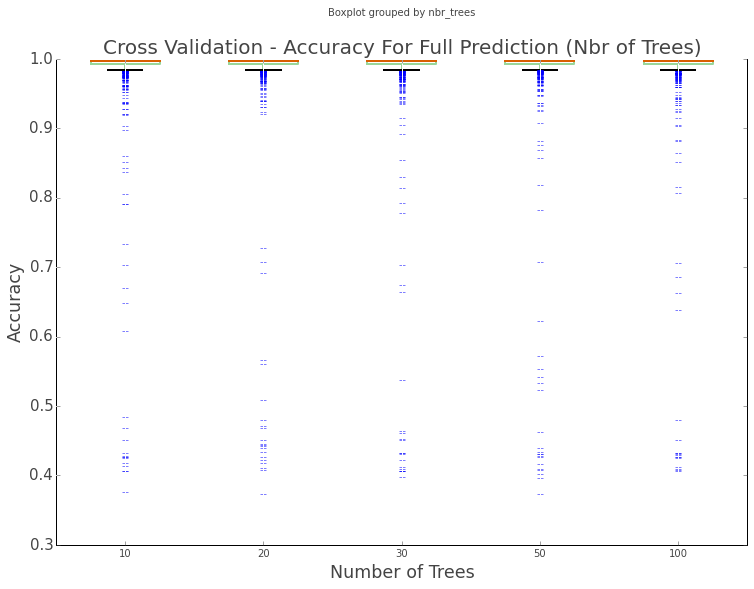

In [235]:
# Plot Distribution of Cross-validation Scores
crossval_accuracy_full.boxplot(column='accuracy', by='nbr_trees')
plt.title('Cross Validation - Accuracy For Full Prediction (Nbr of Trees)')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')

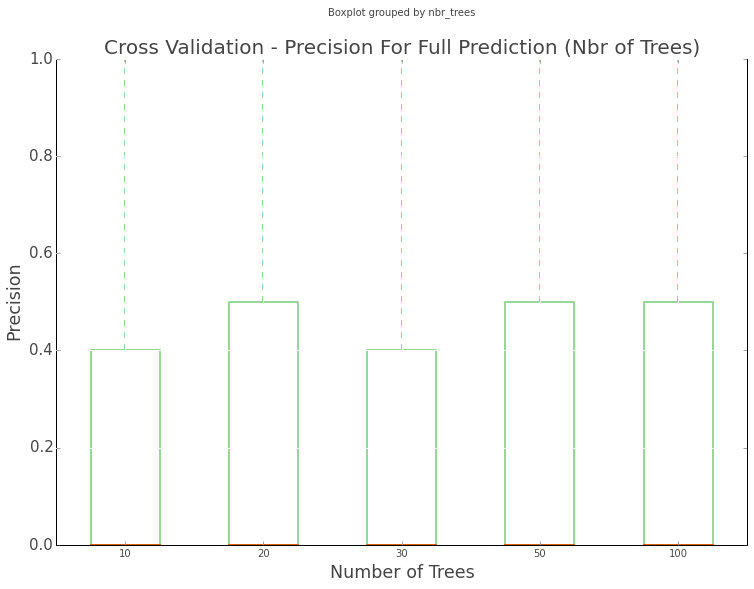

In [236]:
# Plot Distribution of Cross-validation Scores
crossval_precision_full.boxplot(column='precision', by='nbr_trees')
plt.title('Cross Validation - Precision For Full Prediction (Nbr of Trees)')
plt.xlabel('Number of Trees')
plt.ylabel('Precision')

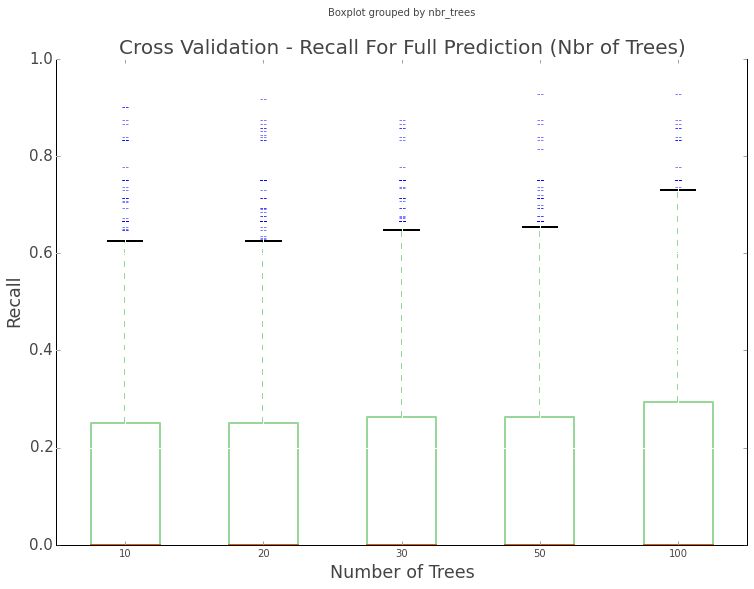

In [237]:
# Plot Distribution of Cross-validation Scores
crossval_recall_full.boxplot(column='recall', by='nbr_trees')
plt.title('Cross Validation - Recall For Full Prediction (Nbr of Trees)')
plt.xlabel('Number of Trees')
plt.ylabel('Recall')

### Computing the classifiers performance

 Test Scores
stations = reg_df_train['dock_id'].unique()

------------ Full Station Prediction ------------##
Preallocate TEST recall full dataframe & Copy Train and test Dataframe
test_recall_full = pd.DataFrame(columns = ['dock_id', 'week', 'hour','P_full','TP_full'])
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness1'])) & (~pd.isnull(reg_df_train['hist_arr']))]
test= reg_df_test.loc[(~pd.isnull(reg_df_test['fullness1'])) & (~pd.isnull(reg_df_test['hist_arr']))]
test['TP_full']=np.nan
test['P_full']=np.nan
test['week']=(test.weekday_x >= 5)*1

Fit Classifier on Training Data as determined from cross validation and predict test data
rdfrst = RandomForestClassifier(n_estimators=20)     
for i,station in enumerate(stations):
    X_train=train.loc[train.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_train=train.isfull[train.dock_id == station]
    X_test= test.loc[test.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_test= test.isfull[test.dock_id == station]
    
    rdfrst.fit(X_train, Y_train)
    preds = rdfrst.predict(X_test)
    test.loc[test.dock_id == station, 'TP_full']=(preds & Y_test)
    test.loc[test.dock_id == station, 'P_full']=Y_test
    rec_gb = test.groupby(['dock_id','week','hour'],as_index=False)['P_full','TP_full'].sum()
    test_recall_empty= pd.concat([test_recall_empty,rec_gb])

### Plotting the RandomForest classifiers performance for Empty and Full

In [244]:
# Aggregate and Print Scores
#class_recall_full = test_recall_full[test_recall_full.week== False].groupby('hour')['TP_full','P_full'].sum()
class_recall_empty = test_recall_empty[test_recall_empty.week== False].groupby('hour')['TP_empty','P_empty'].sum()
class_recall = pd.DataFrame(columns=['Recall_empty'], 
                            index=class_recall_empty.index)
#class_recall.loc[:,'Recall_full']=class_recall_full.TP_full*1.0/class_recall_full.P_full*1.0
class_recall.loc[:,'Recall_empty']=class_recall_empty.TP_empty*1.0/class_recall_empty.P_empty*1.0
#class_recall.plot()
#print "Recall Full: " + str(test_recall_full.TP_full.sum()*1.0/test_recall_full.P_full.sum())
print("Recall Empty: " + str(test_recall_empty.TP_empty.sum()*1.0/test_recall_empty.P_empty.sum()))

Recall Empty: 0.501024629193512


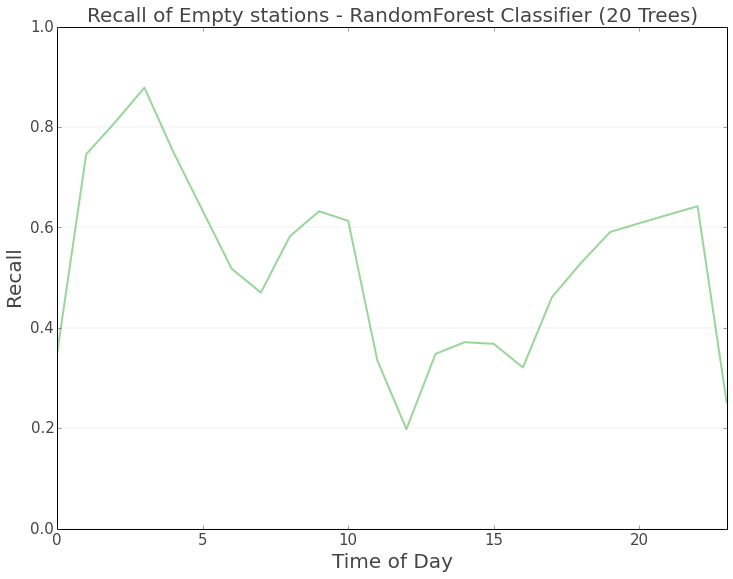

In [245]:
class_recall['Recall_empty'].plot()

plt.ylim(0,1)
plt.xlabel('Time of Day', size =20)
plt.ylabel('Recall', size =20)
plt.grid(color="grey", axis='y', linewidth=0.1,alpha=1)
plt.title('Recall of Empty stations - RandomForest Classifier (20 Trees)')

## Other Classifiers

In [251]:
#import numpy as np
#import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [252]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB()]

In [253]:
 for clf in classifiers:
        print(clf)
        #clf.fit(X_train, y_train)
        #score = clf.score(X_test, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=3, p=2, weights='uniform')
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=2,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
GaussianNB()


### KNeighbours Classifier

In [255]:
##------------ Empty Station Prediction ------------##
stations = reg_df_train['dock_id'].unique()

test_recall_knn = pd.DataFrame(columns = ['dock_id', 'week', 'hour','P_knn','TP_knn'])
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness1'])) & (~pd.isnull(reg_df_train['hist_arr']))]
test= reg_df_test.loc[(~pd.isnull(reg_df_test['fullness1'])) & (~pd.isnull(reg_df_test['hist_arr']))]
test['TP_knn']=np.nan
test['P_knn']=np.nan
test['week']=(test.weekday_x >= 5)*1

# Fit Classifier on Training Data as determined from cross validation and predict test data
knn = KNeighborsClassifier(3)     
for i,station in enumerate(stations):
    X_train=train.loc[train.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_train=train.isempty[train.dock_id == station]
    X_test= test.loc[test.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_test= test.isempty[test.dock_id == station]
    
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_test)
    test.loc[test.dock_id == station, 'TP_knn']=(preds & Y_test)
    test.loc[test.dock_id == station, 'P_knn']=Y_test
    rec_gb = test.groupby(['dock_id','week','hour'],as_index=False)['P_knn','TP_knn'].sum()
    test_recall_knn= pd.concat([test_recall_knn,rec_gb])

### Support Vector Machines Classifiers

In [260]:
##------------ Empty Station Prediction ------------##
stations = reg_df_train['dock_id'].unique()

test_recall_svml = pd.DataFrame(columns = ['dock_id', 'week', 'hour','P_svml','TP_svml'])
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness1'])) & (~pd.isnull(reg_df_train['hist_arr']))]
test= reg_df_test.loc[(~pd.isnull(reg_df_test['fullness1'])) & (~pd.isnull(reg_df_test['hist_arr']))]
test['TP_svml']=np.nan
test['P_svml']=np.nan
test['week']=(test.weekday_x >= 5)*1

# Fit Classifier on Training Data as determined from cross validation and predict test data
svml = SVC(kernel="linear", C=0.025)     
for i,station in enumerate(stations):
    X_train=train.loc[train.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_train=train.isempty[train.dock_id == station]
    X_test= test.loc[test.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_test= test.isempty[test.dock_id == station]
    
    svml.fit(X_train, Y_train)
    preds = svml.predict(X_test)
    test.loc[test.dock_id == station, 'TP_svml']=(preds & Y_test)
    test.loc[test.dock_id == station, 'P_svml']=Y_test
    rec_gb = test.groupby(['dock_id','week','hour'],as_index=False)['P_svml','TP_svml'].sum()
    test_recall_svml= pd.concat([test_recall_svml,rec_gb])

In [261]:
##------------ Empty Station Prediction ------------##
stations = reg_df_train['dock_id'].unique()

test_recall_svmp = pd.DataFrame(columns = ['dock_id', 'week', 'hour','P_svmp','TP_svmp'])
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness1'])) & (~pd.isnull(reg_df_train['hist_arr']))]
test= reg_df_test.loc[(~pd.isnull(reg_df_test['fullness1'])) & (~pd.isnull(reg_df_test['hist_arr']))]
test['TP_svmp']=np.nan
test['P_svmp']=np.nan
test['week']=(test.weekday_x >= 5)*1

# Fit Classifier on Training Data as determined from cross validation and predict test data
svmp = SVC(gamma=2, C=1)     
for i,station in enumerate(stations):
    X_train=train.loc[train.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_train=train.isempty[train.dock_id == station]
    X_test= test.loc[test.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_test= test.isempty[test.dock_id == station]
    
    svmp.fit(X_train, Y_train)
    preds = svmp.predict(X_test)
    test.loc[test.dock_id == station, 'TP_svmp']=(preds & Y_test)
    test.loc[test.dock_id == station, 'P_svmp']=Y_test
    rec_gb = test.groupby(['dock_id','week','hour'],as_index=False)['P_svmp','TP_svmp'].sum()
    test_recall_svmp = pd.concat([test_recall_svmp,rec_gb])

### Decision Tree Classifier

In [258]:
##------------ Empty Station Prediction ------------##
stations = reg_df_train['dock_id'].unique()

test_recall_dt = pd.DataFrame(columns = ['dock_id', 'week', 'hour','P_dt','TP_dt'])
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness1'])) & (~pd.isnull(reg_df_train['hist_arr']))]
test= reg_df_test.loc[(~pd.isnull(reg_df_test['fullness1'])) & (~pd.isnull(reg_df_test['hist_arr']))]
test['TP_dt']=np.nan
test['P_dt']=np.nan
test['week']=(test.weekday_x >= 5)*1

# Fit Classifier on Training Data as determined from cross validation and predict test data
dt = DecisionTreeClassifier(max_depth=5)     
for i,station in enumerate(stations):
    X_train=train.loc[train.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_train=train.isempty[train.dock_id == station]
    X_test= test.loc[test.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_test= test.isempty[test.dock_id == station]
    
    dt.fit(X_train, Y_train)
    preds = dt.predict(X_test)
    test.loc[test.dock_id == station, 'TP_dt']=(preds & Y_test)
    test.loc[test.dock_id == station, 'P_dt']=Y_test
    rec_gb = test.groupby(['dock_id','week','hour'],as_index=False)['P_dt','TP_dt'].sum()
    test_recall_dt = pd.concat([test_recall_dt,rec_gb])

### Naive Bayes Classifier

In [259]:
##------------ Empty Station Prediction ------------##
stations = reg_df_train['dock_id'].unique()

test_recall_nb = pd.DataFrame(columns = ['dock_id', 'week', 'hour','P_nb','TP_nb'])
train= reg_df_train.loc[(~pd.isnull(reg_df_train['fullness1'])) & (~pd.isnull(reg_df_train['hist_arr']))]
test= reg_df_test.loc[(~pd.isnull(reg_df_test['fullness1'])) & (~pd.isnull(reg_df_test['hist_arr']))]
test['TP_nb']=np.nan
test['P_nb']=np.nan
test['week']=(test.weekday_x >= 5)*1

# Fit Classifier on Training Data as determined from cross validation and predict test data
nb = GaussianNB()     
for i,station in enumerate(stations):
    X_train=train.loc[train.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_train=train.isempty[train.dock_id == station]
    X_test= test.loc[test.dock_id == station, 
                          ['temp','month_x','hour','weekday_x','hist_arr','hist_dep','avg_arr_1','avg_dep_1','fullness1']]
    Y_test= test.isempty[test.dock_id == station]
    
    nb.fit(X_train, Y_train)
    preds = nb.predict(X_test)
    test.loc[test.dock_id == station, 'TP_nb']=(preds & Y_test)
    test.loc[test.dock_id == station, 'P_nb']=Y_test
    rec_gb = test.groupby(['dock_id','week','hour'],as_index=False)['P_nb','TP_nb'].sum()
    test_recall_nb= pd.concat([test_recall_nb,rec_gb])

In [263]:
# Aggregate and Print Scores
class_recall_knn = test_recall_knn[test_recall_knn.week== False].groupby('hour')['TP_knn','P_knn'].sum()
class_recall_svml = test_recall_svml[test_recall_svml.week== False].groupby('hour')['TP_svml','P_svml'].sum()
class_recall_svmp = test_recall_svmp[test_recall_svmp.week== False].groupby('hour')['TP_svmp','P_svmp'].sum()
class_recall_dt = test_recall_dt[test_recall_dt.week== False].groupby('hour')['TP_dt','P_dt'].sum()
class_recall_nb = test_recall_nb[test_recall_nb.week== False].groupby('hour')['TP_nb','P_nb'].sum()
class_recall = pd.DataFrame(columns=['Recall_knn','Recall_svml','Recall_svmp','Recall_dt','Recall_nb'], 
index=class_recall_knn.index)
class_recall.loc[:,'Recall_knn']=class_recall_knn.TP_knn*1.0/class_recall_knn.P_knn*1.0
class_recall.loc[:,'Recall_svml']=class_recall_svml.TP_svml*1.0/class_recall_svml.P_svml*1.0
class_recall.loc[:,'Recall_svmp']=class_recall_svmp.TP_svmp*1.0/class_recall_svmp.P_svmp*1.0
class_recall.loc[:,'Recall_dt']=class_recall_dt.TP_dt*1.0/class_recall_dt.P_dt*1.0
class_recall.loc[:,'Recall_nb']=class_recall_nb.TP_nb*1.0/class_recall_nb.P_nb*1.0
#class_recall.plot()
print("Recall Knn: " + str(test_recall_knn.TP_knn.sum()*1.0/test_recall_knn.P_knn.sum()))
print("Recall SVM Linear: " + str(test_recall_svml.TP_svml.sum()*1.0/test_recall_svml.P_svml.sum()))
print("Recall SVM Polynomial: " + str(test_recall_svmp.TP_svmp.sum()*1.0/test_recall_svmp.P_svmp.sum()))
print("Recall Decision Trees: " + str(test_recall_dt.TP_dt.sum()*1.0/test_recall_dt.P_dt.sum()))
print("Recall NaiveBayes: " + str(test_recall_nb.TP_nb.sum()*1.0/test_recall_nb.P_nb.sum()))

Recall Knn: 0.3564573702028626
Recall SVM Linear: 0.06977785997716841
Recall SVM Polynomial: 0.003372339165793777
Recall Decision Trees: 0.5078220514956966
Recall NaiveBayes: 0.6586318869017589


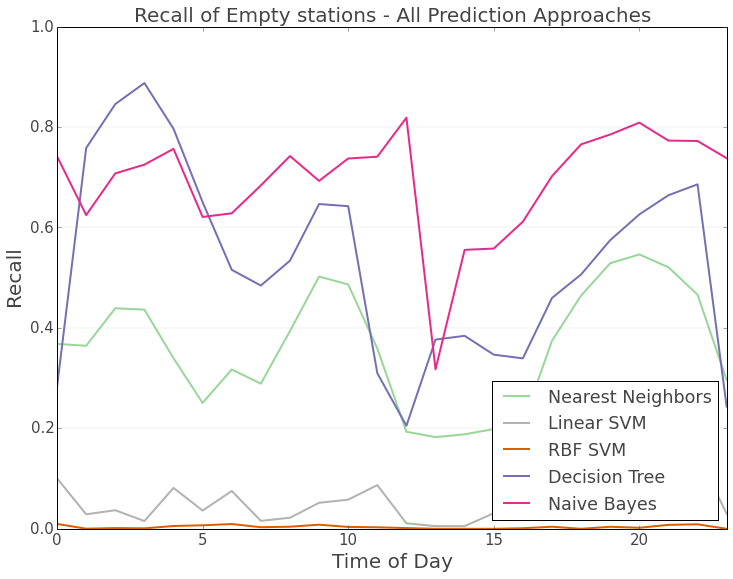

In [264]:
# Recall Empty Plots
class_recall['Recall_knn'].plot()
class_recall['Recall_svml'].plot()
class_recall['Recall_svmp'].plot()
class_recall['Recall_dt'].plot()
class_recall['Recall_nb'].plot()

plt.ylim(0,1)
plt.xlabel('Time of Day', size =20)
plt.ylabel('Recall', size =20)
plt.legend(names, loc="lower right")
plt.grid(color="grey", axis='y', linewidth=0.1,alpha=1)
plt.title('Recall of Empty stations - All Prediction Approaches');